# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [226]:

# Check versions
print("numpy version:",np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [228]:
# Try loading one file

df = pd.read_parquet('/content/drive/MyDrive/2023-1.parquet')

In [229]:
#df.info()

In [230]:
#df.isnull().sum()

In [231]:
#df['tpep_pickup_datetime']

In [232]:
#Hour_of_pickup = df['tpep_pickup_datetime'].dt.hour

In [233]:
#Hour_of_pickup

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [234]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [235]:
 #from google.colab import drive
 #drive.mount('/content/drive')

In [236]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir('/content/drive/MyDrive/trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        df_temp = pd.read_parquet(file_path)
        df_temp['te'] = pd.to_datetime(df_temp['tpep_pickup_datetime']).dt.date
        df_temp['th'] = pd.to_datetime(df_temp['tpep_pickup_datetime']).dt.hour



        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for date in df_temp['te'].unique():
            day_data = df_temp[df_temp['te'] == date]

            # Iterate through each hour of the selected date
            for hour in day_data['th'].unique():
                hour_data = day_data[day_data['th'] == hour]

                # Sample 5% of the hourly data randomly
                sample = hour_data.sample(frac = 0.05, random_state = 42)

                # Append the sampled data to the dataframe
                sampled_data = pd.concat([sampled_data, sample], ignore_index=True)


                # add data of this hour to the dataframe


        # Concatenate the sampled data of all the dates to a single dataframe
        df =  pd.concat([df, sampled_data], ignore_index=True) # we initialised this empty DF earlier

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Error reading file df_sampled1.csv: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Error reading file notebook_archive.zip: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Error reading file EDA_Optimising_NYC_Taxis_Jayesh.zip: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [237]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106348 entries, 0 to 2106347
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [238]:
#df.columns

In [239]:
#df.shape

In [240]:
df.drop(['Extra','Mta_tax','Improvement_surcharge','Total_amount','Congestion_surcharge', 'Airport_fEE_','AIrport_Fee'],axis=1,inplace=True)

In [241]:
#df.shape

In [242]:
# Store the df in csv/parquet
df.to_parquet('df_sampled.parquet')

In [243]:
df_sampled = pd.read_parquet('df_sampled.parquet')

In [244]:
#df_sampled.info()

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [245]:
# Load the new data file

df_sampled

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1               2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2               2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3               2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4               2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   
...           ...                  ...                   ...              ...   
2106343         1  2023-12-31 23:06:14   2023-12-31 23:29:47              1.0   
2106344         2  2023-12-31 23:05:44   2023-12-31 23:13:31              1.0   
2106345         2  2023-12-31 23:16:11   2023-12-31 23:56:35              1.0   
2106346         2  2023-12-31 23:16:11   2023-12-31 23:56:35              1.0   
2106347         2  2023-12-31 23:37:20   2023-12-31 23:41:18              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                 7.74         1.0                  N           138   
1                 1.24         1.0                  N           161   
2                 1.44         1.0                  N           237   
3                 0.54         1.0                  N           143   
4                19.24         NaN               None            66   
...                ...         ...                ...           ...   
2106343           8.50         1.0                  N           141   
2106344           1.75         1.0                  N            42   
2106345           5.52         1.0                  N           158   
2106346           5.52         1.0                  N           158   
2106347           1.06         1.0                  N            79   

         DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0                 256             2  ...      0.5        0.00           0.0   
1                 237             1  ...      0.5        2.58           0.0   
2                 141             2  ...      0.5        0.00           0.0   
3                 142             2  ...      0.5        0.00           0.0   
4                 107             0  ...      0.5        5.93           0.0   
...               ...           ...  ...      ...         ...           ...   
2106343            95             1  ...      NaN        3.00           0.0   
2106344           168             2  ...      NaN        0.00           0.0   
2106345           151             1  ...      NaN        9.16           0.0   
2106346           151             1  ...      NaN        9.16           0.0   
2106347           137             1  ...      NaN        2.44           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
0                          1.0         41.15                   0.0   
1                          1.0         15.48                   2.5   
2                          1.0         16.40                   2.5   
3                          1.0         11.50                   2.5   
4                          1.0         35.57                   NaN   
...                        ...           ...                   ...   
2106343                    NaN           NaN                   NaN   
2106344                    NaN           NaN                   NaN   
2106345                    NaN           NaN                   NaN   
2106346                    NaN           NaN                   NaN   
2106347                    NaN           NaN                   NaN   

         airport_fee          te  th Airport_fee  
0               1.25  2023-01-01   0         NaN  
1               0.00  2023-01-01   0         NaN  
2               0.00  2023-01-01   0         NaN  
3               0.00  2023-01-01   0         NaN  
4                NaN  2023-01-01   0         NaN  
...              ...         ...  ..         ...  
2106343          NaN  2023-12-31  23

In [246]:
# df.head()
df_sampled.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN               None            66           107   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        2.58           0.0   
2             2  ...      0.5        0.00           0.0   
3             2  ...      0.5        0.00           0.0   
4             0  ...      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

           te  th Airport_fee  
0  2023-01-01   0         NaN  
1  2023-01-01   0         NaN  
2  2023-01-01   0         NaN  
3  2023-01-01   0         NaN  
4  2023-01-01   0         NaN  

[5 rows x 22 columns]

In [247]:

#df_sampled.info()

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [248]:
# Fix the index and drop any columns that are not needed
df_sampled.reset_index(drop=True, inplace=True)
df_sampled.head()


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN               None            66           107   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        2.58           0.0   
2             2  ...      0.5        0.00           0.0   
3             2  ...      0.5        0.00           0.0   
4             0  ...      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

           te  th Airport_fee  
0  2023-01-01   0         NaN  
1  2023-01-01   0         NaN  
2  2023-01-01   0         NaN  
3  2023-01-01   0         NaN  
4  2023-01-01   0         NaN  

[5 rows x 22 columns]

In [249]:
df_sampled.shape

(2106348, 22)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [250]:
#df_sampled.columns

In [251]:
#df_sampled.airport_fee.value_counts()

In [252]:
#df_sampled.Airport_fee.value_counts()

In [253]:
# Combine the two airport fee columns

df_sampled['AIRPORT_Fee'] = df_sampled['Airport_fee'] + df_sampled['airport_fee']


In [254]:
#df_sampled.columns

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [255]:
#df_sampled

In [256]:
# check where values of fare amount are negative
df_sampled[df_sampled['fare_amount'] < 0]



Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, te, th, Airport_fee, AIRPORT_Fee]
Index: []

[0 rows x 23 columns]

In [257]:
#df_sampled.fare_amount.describe()

In [258]:
#df_sampled.fare_amt.describe()

In [259]:
df_sampled.fare_amount.min()

0.0

In [260]:
#df.fare_amount.nunique()

Did you notice something different in the `RatecodeID` column for above records?

In [261]:
# Analyse RatecodeID for the negative fare amounts
df_sampled[df_sampled['fare_amount'] < 0]['RatecodeID']



Series([], Name: RatecodeID, dtype: float64)

In [262]:
#df_sampled.isnull().sum()

In [263]:
#df_sampled.info()

In [264]:
# Find which columns have negative value
num = df_sampled.select_dtypes(include=['number'])
num.head()



VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
0         2              1.0           7.74         1.0           138   
1         2              2.0           1.24         1.0           161   
2         2              3.0           1.44         1.0           237   
3         2              1.0           0.54         1.0           143   
4         2              NaN          19.24         NaN            66   

   DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
0           256             2        32.40    6.0      0.5        0.00   
1           237             1         7.90    1.0      0.5        2.58   
2           141             2        11.40    1.0      0.5        0.00   
3           142             2         6.50    1.0      0.5        0.00   
4           107             0        25.64    0.0      0.5        5.93   

   tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  \
0           0.0                    1.0         41.15                   0.0   
1           0.0                    1.0         15.48                   2.5   
2           0.0                    1.0         16.40                   2.5   
3           0.0                    1.0         11.50                   2.5   
4           0.0                    1.0         35.57                   NaN   

   airport_fee  th  Airport_fee  AIRPORT_Fee  
0         1.25   0          NaN          NaN  
1         0.00   0          NaN          NaN  
2         0.00   0          NaN          NaN  
3         0.00   0          NaN          NaN  
4          NaN   0          NaN          NaN

In [265]:
#type(df_sampled)

In [266]:
#type(num)

In [267]:
#num.dtypes

In [268]:
num.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'th',
       'Airport_fee', 'AIRPORT_Fee'],
      dtype='object')

In [269]:
#num.columns.nunique()

In [270]:
columns_with_negative = num[num.columns[(num < 0).any()]]

In [271]:
columns_with_negative.head()

extra  mta_tax  improvement_surcharge  total_amount  congestion_surcharge  \
0    6.0      0.5                    1.0         41.15                   0.0   
1    1.0      0.5                    1.0         15.48                   2.5   
2    1.0      0.5                    1.0         16.40                   2.5   
3    1.0      0.5                    1.0         11.50                   2.5   
4    0.0      0.5                    1.0         35.57                   NaN   

   airport_fee  Airport_fee  
0         1.25          NaN  
1         0.00          NaN  
2         0.00          NaN  
3         0.00          NaN  
4          NaN          NaN

In [272]:
#num.head()

In [273]:
columns_with_negative.describe()

extra       mta_tax  improvement_surcharge  total_amount  \
count  1.994684e+06  1.994684e+06           1.994684e+06  1.994684e+06   
mean   1.587826e+00  4.952754e-01           9.989739e-01  2.898219e+01   
std    1.829173e+00  4.885557e-02           3.107728e-02  1.038857e+02   
min   -2.500000e+00 -5.000000e-01          -1.000000e+00 -5.750000e+00   
25%    0.000000e+00  5.000000e-01           1.000000e+00  1.596000e+01   
50%    1.000000e+00  5.000000e-01           1.000000e+00  2.100000e+01   
75%    2.500000e+00  5.000000e-01           1.000000e+00  3.094000e+01   
max    2.080000e+01  4.000000e+00           1.000000e+00  1.431675e+05   

       congestion_surcharge    airport_fee   Airport_fee  
count          1.926608e+06  156196.000000  1.770412e+06  
mean           2.307556e+00       0.109254  1.459766e-01  
std            6.666770e-01       0.353060  4.735124e-01  
min           -2.500000e+00      -1.250000 -1.750000e+00  
25%            2.500000e+00       0.000000  0.000000e+00  
50%            2.500000e+00       0.000000  0.000000e+00  
75%            2.500000e+00       0.000000  0.000000e+00  
max            2.500000e+00       1.250000  1.750000e+00

In [274]:
# fix these negative values

columns_with_negative['extra'] = columns_with_negative['extra'].mask(columns_with_negative['extra'] < 0)
columns_with_negative['extra'] = columns_with_negative['extra'].fillna(columns_with_negative['extra'].median())
columns_with_negative['mta_tax'] = columns_with_negative['mta_tax'].mask(columns_with_negative['mta_tax'] < 0)
columns_with_negative['mta_tax'] = columns_with_negative['mta_tax'].fillna(columns_with_negative['mta_tax'].median())
columns_with_negative['improvement_surcharge'] = columns_with_negative['improvement_surcharge'].mask(columns_with_negative['improvement_surcharge'] < 0)
columns_with_negative['improvement_surcharge'] = columns_with_negative['improvement_surcharge'].fillna(columns_with_negative['improvement_surcharge'].median())
columns_with_negative['total_amount'] = columns_with_negative['total_amount'].mask(columns_with_negative['total_amount'] < 0)
columns_with_negative['total_amount'] = columns_with_negative['total_amount'].fillna(columns_with_negative['total_amount'].median())
columns_with_negative['congestion_surcharge'] = columns_with_negative['congestion_surcharge'].mask(columns_with_negative['congestion_surcharge'] < 0)
columns_with_negative['congestion_surcharge'] = columns_with_negative['congestion_surcharge'].fillna(columns_with_negative['congestion_surcharge'].median())
columns_with_negative['airport_fee'] = columns_with_negative['airport_fee'].mask(columns_with_negative['airport_fee'] < 0)
columns_with_negative['airport_fee'] = columns_with_negative['airport_fee'].fillna(columns_with_negative['airport_fee'].median())
columns_with_negative['Airport_fee'] = columns_with_negative['Airport_fee'].mask(columns_with_negative['Airport_fee'] < 0)
columns_with_negative['Airport_fee'] = columns_with_negative['Airport_fee'].fillna(columns_with_negative['Airport_fee'].median())

<ipython-input-274-3d420c490ccd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns_with_negative['extra'] = columns_with_negative['extra'].mask(columns_with_negative['extra'] < 0)
<ipython-input-274-3d420c490ccd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns_with_negative['extra'] = columns_with_negative['extra'].fillna(columns_with_negative['extra'].median())
<ipython-input-274-3d420c490ccd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [275]:
columns_with_negative.columns

Index(['extra', 'mta_tax', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'Airport_fee'],
      dtype='object')

In [276]:
columns_with_negative.describe()

extra       mta_tax  improvement_surcharge  total_amount  \
count  2.106348e+06  2.106348e+06           2.106348e+06  2.106348e+06   
mean   1.556667e+00  4.955619e-01           9.991061e-01  2.855998e+01   
std    1.784890e+00  4.717724e-02           2.755133e-02  1.011101e+02   
min    0.000000e+00  0.000000e+00           0.000000e+00  0.000000e+00   
25%    0.000000e+00  5.000000e-01           1.000000e+00  1.630000e+01   
50%    1.000000e+00  5.000000e-01           1.000000e+00  2.100000e+01   
75%    2.500000e+00  5.000000e-01           1.000000e+00  3.000000e+01   
max    2.080000e+01  4.000000e+00           1.000000e+00  1.431675e+05   

       congestion_surcharge   airport_fee   Airport_fee  
count          2.106348e+06  2.106348e+06  2.106348e+06  
mean           2.324118e+00  8.102294e-03  1.227061e-01  
std            6.393521e-01  1.003106e-01  4.373675e-01  
min            0.000000e+00  0.000000e+00  0.000000e+00  
25%            2.500000e+00  0.000000e+00  0.000000e+00  
50%            2.500000e+00  0.000000e+00  0.000000e+00  
75%            2.500000e+00  0.000000e+00  0.000000e+00  
max            2.500000e+00  1.250000e+00  1.750000e+00

In [277]:
#df_sampled.describe()

In [278]:
columns_with_negative.columns

Index(['extra', 'mta_tax', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'Airport_fee'],
      dtype='object')

In [279]:
columns_with_negative.rename(columns={'extra':'Extra' ,'mta_tax':'Mta_tax','improvement_surcharge':'Improvement_surcharge','total_amount':'Total_amount','congestion_surcharge':'Congestion_surcharge','airport_fee':'Airport_fEE_','Airport_fee':'AIrport_Fee'},inplace=True)

<ipython-input-279-7b4481d5e236>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns_with_negative.rename(columns={'extra':'Extra' ,'mta_tax':'Mta_tax','improvement_surcharge':'Improvement_surcharge','total_amount':'Total_amount','congestion_surcharge':'Congestion_surcharge','airport_fee':'Airport_fEE_','Airport_fee':'AIrport_Fee'},inplace=True)


In [280]:
columns_with_negative.describe()

Extra       Mta_tax  Improvement_surcharge  Total_amount  \
count  2.106348e+06  2.106348e+06           2.106348e+06  2.106348e+06   
mean   1.556667e+00  4.955619e-01           9.991061e-01  2.855998e+01   
std    1.784890e+00  4.717724e-02           2.755133e-02  1.011101e+02   
min    0.000000e+00  0.000000e+00           0.000000e+00  0.000000e+00   
25%    0.000000e+00  5.000000e-01           1.000000e+00  1.630000e+01   
50%    1.000000e+00  5.000000e-01           1.000000e+00  2.100000e+01   
75%    2.500000e+00  5.000000e-01           1.000000e+00  3.000000e+01   
max    2.080000e+01  4.000000e+00           1.000000e+00  1.431675e+05   

       Congestion_surcharge  Airport_fEE_   AIrport_Fee  
count          2.106348e+06  2.106348e+06  2.106348e+06  
mean           2.324118e+00  8.102294e-03  1.227061e-01  
std            6.393521e-01  1.003106e-01  4.373675e-01  
min            0.000000e+00  0.000000e+00  0.000000e+00  
25%            2.500000e+00  0.000000e+00  0.000000e+00  
50%            2.500000e+00  0.000000e+00  0.000000e+00  
75%            2.500000e+00  0.000000e+00  0.000000e+00  
max            2.500000e+00  1.250000e+00  1.750000e+00

In [281]:
#columns_with_negative.columns

In [282]:
df_sampled.reset_index(drop=True, inplace=True)
columns_with_negative.reset_index(drop=True, inplace=True)

In [283]:
df_sampled = pd.concat([df_sampled, columns_with_negative], axis=1)


In [284]:
df_sampled.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN               None            66           107   

   payment_type  ...  th  Airport_fee  AIRPORT_Fee  Extra  Mta_tax  \
0             2  ...   0          NaN          NaN    6.0      0.5   
1             1  ...   0          NaN          NaN    1.0      0.5   
2             2  ...   0          NaN          NaN    1.0      0.5   
3             2  ...   0          NaN          NaN    1.0      0.5   
4             0  ...   0          NaN          NaN    0.0      0.5   

   Improvement_surcharge  Total_amount  Congestion_surcharge  Airport_fEE_  \
0                    1.0         41.15                   0.0          1.25   
1                    1.0         15.48                   2.5          0.00   
2                    1.0         16.40                   2.5          0.00   
3                    1.0         11.50                   2.5          0.00   
4                    1.0         35.57                   2.5          0.00   

  AIrport_Fee  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 30 columns]

In [285]:
#df_sampled.columns

In [286]:
#df_sampled.describe()

In [287]:
df_sampled.drop(['extra', 'mta_tax','improvement_surcharge','total_amount','congestion_surcharge','airport_fee','Airport_fee'], axis=1, inplace=True)

In [288]:
df_sampled.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'te', 'th', 'AIRPORT_Fee', 'Extra',
       'Mta_tax', 'Improvement_surcharge', 'Total_amount',
       'Congestion_surcharge', 'Airport_fEE_', 'AIrport_Fee'],
      dtype='object')

In [289]:
df_sampled.shape

(2106348, 23)

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [290]:
# Find the proportion of missing values in each column

(df_sampled.isnull().sum()/len(df_sampled))*100

VendorID                   0.000000
tpep_pickup_datetime       0.000000
tpep_dropoff_datetime      0.000000
passenger_count            3.231945
trip_distance              0.000000
RatecodeID                 3.231945
store_and_fwd_flag         3.231945
PULocationID               0.000000
DOLocationID               0.000000
payment_type               0.000000
fare_amount                0.000000
tip_amount                 0.000000
tolls_amount               0.000000
te                         0.000000
th                         0.000000
AIRPORT_Fee              100.000000
Extra                      0.000000
Mta_tax                    0.000000
Improvement_surcharge      0.000000
Total_amount               0.000000
Congestion_surcharge       0.000000
Airport_fEE_               0.000000
AIrport_Fee                0.000000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [291]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
passenger_median = df_sampled['passenger_count'].median()
df_sampled['passenger_count'] = df_sampled['passenger_count'].fillna(passenger_median)

In [292]:
df_sampled.passenger_count.value_counts()

passenger_count
1.0    1601746
2.0     307974
3.0      76616
4.0      42859
0.0      32997
5.0      26539
6.0      17596
8.0         11
9.0          5
7.0          5
Name: count, dtype: int64

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [293]:
df_sampled['RatecodeID'].dtype

dtype('float64')

In [294]:
# Fix missing values in 'RatecodeID'
df_sampled['RatecodeID'] = df_sampled['RatecodeID'].fillna(df_sampled['RatecodeID'].median())

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [295]:
#df_sampled['Congestion_surcharge'].dtype

In [296]:
# handle null values in congestion_surcharge


df_sampled['Congestion_surcharge'] = df_sampled['Congestion_surcharge'].fillna(df_sampled['Congestion_surcharge'].median())

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [297]:
# Handle any remaining missing values
df_sampled.isnull().sum()


VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count                0
trip_distance                  0
RatecodeID                     0
store_and_fwd_flag         68076
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
tip_amount                     0
tolls_amount                   0
te                             0
th                             0
AIRPORT_Fee              2106348
Extra                          0
Mta_tax                        0
Improvement_surcharge          0
Total_amount                   0
Congestion_surcharge           0
Airport_fEE_                   0
AIrport_Fee                    0
dtype: int64

In [298]:
df_sampled['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    2025811
Y      12461
Name: count, dtype: int64

In [299]:
df_sampled.store_and_fwd_flag.mode()[0]

'N'

In [300]:
df_sampled['store_and_fwd_flag'] = df_sampled['store_and_fwd_flag'].fillna(df_sampled['store_and_fwd_flag'].mode()[0])

In [301]:
df_sampled.drop(['AIRPORT_Fee'], axis=1, inplace=True)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [302]:
df_sampled.shape

(2106348, 22)

In [303]:
df_sampled.to_parquet('df_sampled1.parquet')

In [304]:
df_sampled1 = pd.read_parquet('df_sampled1.parquet')

In [305]:
#df_sampled1.info()

In [306]:
os.getcwd()

'/content/drive/MyDrive/trip_records'

In [307]:
#df_sampled.to_parquet('df_sampled1.parquet')
#from google.colab import files
#files.download('df_sampled1.parquet')

In [308]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns



In [309]:
#df_sampled1.describe()

In [310]:
#df_sampled1.isnull().sum()

In [311]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

numeric_cols = df_sampled1.select_dtypes(include=['float64', 'int64']).columns
outlier_report = {}

for col in numeric_cols:
    outliers = detect_outliers_iqr(df_sampled1, col)
    if not outliers.empty:
        outlier_report[col] = len(outliers)

In [312]:
outlier_report

{'VendorID': 500,
 'passenger_count': 504602,
 'trip_distance': 277296,
 'RatecodeID': 113763,
 'payment_type': 448248,
 'fare_amount': 219417,
 'tip_amount': 161869,
 'tolls_amount': 171008,
 'Extra': 35836,
 'Mta_tax': 18810,
 'Improvement_surcharge': 2286,
 'Total_amount': 242700,
 'Congestion_surcharge': 148188,
 'Airport_fEE_': 13653,
 'AIrport_Fee': 155770}

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [313]:
# 1. Trip distance ≈ 0 but fare > 300
condition_1 = df_sampled1[(df_sampled1["trip_distance"] <= 0.1) & (df_sampled1["fare_amount"] > 300)]

# 2. Trip distance = 0, fare = 0, but zones are different
condition_2 = df_sampled1[
    (df_sampled1["trip_distance"] == 0) &
    (df_sampled1["fare_amount"] == 0) &
    (df_sampled1["PULocationID"] != df_sampled1["DOLocationID"])
]

# 3. Trip distance > 250 miles
condition_3 = df_sampled1[df_sampled1["trip_distance"] > 250]

# 4. payment_type == 0 (invalid code)
condition_4 = df_sampled1[df_sampled1["payment_type"] == 0]

# STEP 4: Report summary
print("=== Summary of Suspicious Records ===")
print(f"1. Trip distance ≈ 0 and fare > 300: {len(condition_1)}")
print(f"2. Zero fare & distance but zones differ: {len(condition_2)}")
print(f"3. Trip distance > 250 miles: {len(condition_3)}")
print(f"4. Invalid payment_type (0): {len(condition_4)}")

=== Summary of Suspicious Records ===
1. Trip distance ≈ 0 and fare > 300: 41
2. Zero fare & distance but zones differ: 73
3. Trip distance > 250 miles: 48
4. Invalid payment_type (0): 71710


In [314]:
# remove passenger_count > 6
df_sampled1 = df_sampled1[df_sampled1['passenger_count'] <= 6]

In [315]:
#from google.colab import files
#files.download('df_sampled1.parquet')

In [316]:
numeric_cols

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'Extra', 'Mta_tax',
       'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge',
       'Airport_fEE_', 'AIrport_Fee'],
      dtype='object')

In [317]:
# Continue with outlier handling
for col in numeric_cols:
    q1=df_sampled1[col].describe()["25%"] # Q1 - 25th Percentile
    q3=df_sampled1[col].describe()["75%"] # Q3 - 75th Percentile
    iqr=q3-q1                     # IQR - InterQuartile Range
    lower_whisker=q1-1.5*iqr      # Lower Bound
    upper_whisker=q3+1.5*iqr      # Upper Bound
    #np.where(condition,what to do if condition is true, what to do if condition is false)
    #print(df1[df1[col]<lower_whisker])
    #print(df1[df1[col]>upper_whisker])
    df_sampled1[col]=np.where(df_sampled1[col]<lower_whisker,lower_whisker,df_sampled1[col]) # Flooring
    df_sampled1[col]=np.where(df_sampled1[col]>upper_whisker,upper_whisker,df_sampled1[col]) # Capping/Ceiling


<ipython-input-317-fae4548c8cff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sampled1[col]=np.where(df_sampled1[col]<lower_whisker,lower_whisker,df_sampled1[col]) # Flooring
<ipython-input-317-fae4548c8cff>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sampled1[col]=np.where(df_sampled1[col]>upper_whisker,upper_whisker,df_sampled1[col]) # Capping/Ceiling


In [318]:
#df_sampled1.columns

In [319]:
# Do any columns need standardising?

#from sklearn.preprocessing import StandardScaler

# List of numeric columns to standardize
#cols_to_standardize = ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount','Total_amount', 'Congestion_surcharge', 'Extra', 'Mta_tax','Improvement_surcharge', 'Airport_fEE_', 'AIrport_Fee', 'te', 'th']


# Initialize the scaler
#scaler = StandardScaler()

# Fit and transform the numeric columns
#df_standardized = df_sampled1.copy()  # work on a copy to preserve original
#df_standardized[cols_to_standardize] = scaler.fit_transform(df_real[cols_to_standardize])

# Preview the standardized data
#print(df_standardized[cols_to_standardize].head())

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [320]:
#df_sampled1.columns.tolist()

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [321]:
df = df_sampled1.copy()

# Initialize empty lists
numerical_cols = []
categorical_cols = []
datetime_cols = []

# Loop through each column and categorize
for col in df.columns:
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        datetime_cols.append(col)
    elif pd.api.types.is_numeric_dtype(df[col]):
        # Treat "ID"-like numeric columns as categorical
        if 'ID' in col or 'id' in col or col.lower() in ['vendorid', 'ratecodeid', 'payment_type', 'passenger_count']:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
    else:
        categorical_cols.append(col)

# Display the results
print("📦 Numerical columns:")
print(numerical_cols)

print("\n🏷️ Categorical columns:")
print(categorical_cols)

print("\n⏱️ Datetime columns:")
print(datetime_cols)

📦 Numerical columns:
['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'th', 'Extra', 'Mta_tax', 'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge', 'Airport_fEE_', 'AIrport_Fee']

🏷️ Categorical columns:
['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'te']

⏱️ Datetime columns:
['tpep_pickup_datetime', 'tpep_dropoff_datetime']


##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [322]:
#df_sampled1.to_csv('df_sampled1.csv')
#from google.colab import files
#files.download('df_sampled1.csv')

In [323]:
#df_sampled1.columns

In [324]:
# Find and show the hourly trends in taxi pickups

df_sampled1['th'].value_counts()

th
18    148784
17    142040
19    132897
16    130544
15    130408
14    127143
13    118637
20    118392
21    118287
12    115065
22    109618
11    106008
10     97637
9      89941
23     86788
8      79762
0      59601
7      57546
1      39996
6      29178
2      26387
3      17429
5      12404
4      11835
Name: count, dtype: int64

In [325]:
df_sampled1['pickup_day'] = df_sampled1['tpep_pickup_datetime'].dt.day_name()

In [326]:
#df_sampled1.head()

<ipython-input-327-500f220dabdd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sampled1, x='pickup_day', palette='viridis')


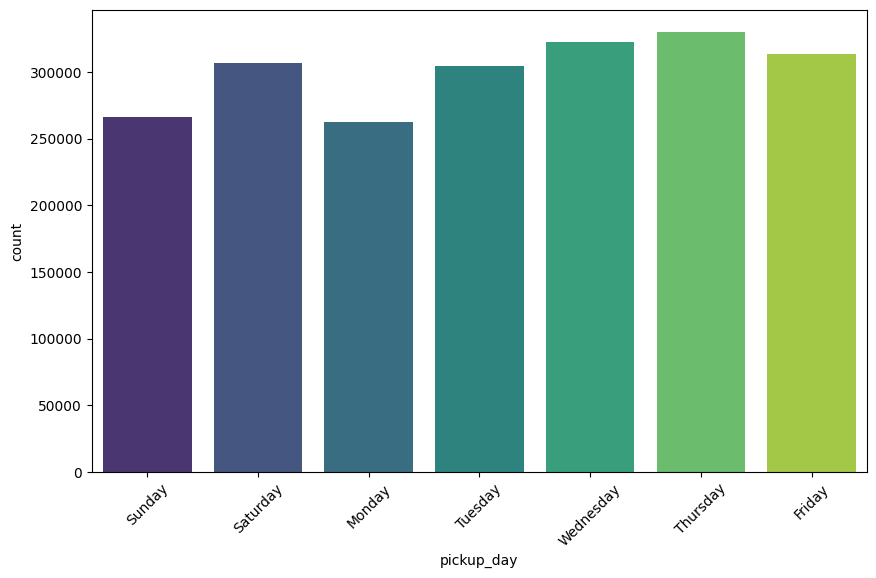

In [327]:
# Find and show the daily trends in taxi pickups (days of the week)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sampled1, x='pickup_day', palette='viridis')
plt.xticks(rotation=45)
plt.show()


In [328]:
df_sampled1['pickup_month'] = df_sampled1['tpep_pickup_datetime'].dt.month_name()

<ipython-input-329-428d864533f3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sampled1, x='pickup_month', palette='viridis')


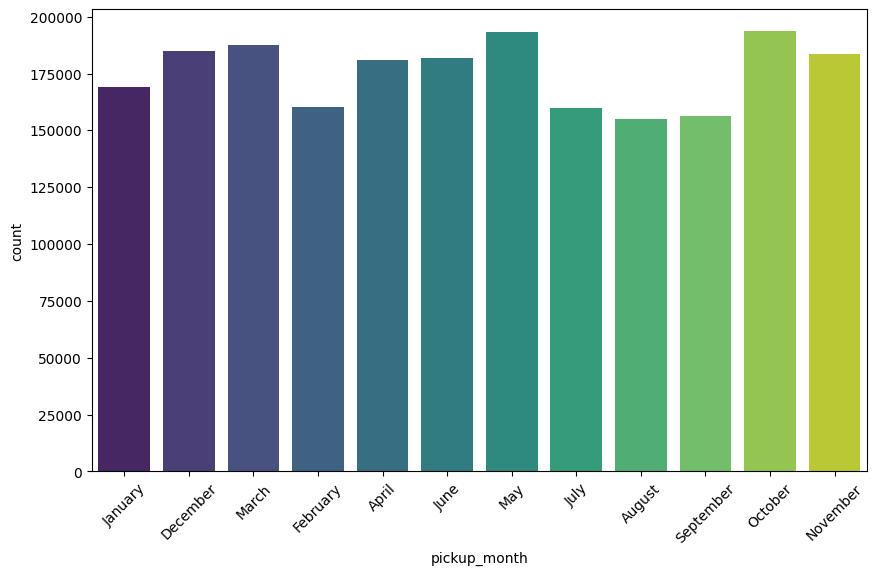

In [329]:
# Show the monthly trends in pickups
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sampled1, x='pickup_month', palette='viridis')
plt.xticks(rotation=45)
plt.show()




In [330]:
df_sampled1.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1       2.0  2023-01-01 00:16:41   2023-01-01 00:21:46              1.0   
2       2.0  2023-01-01 00:14:03   2023-01-01 00:24:36              1.0   
3       2.0  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4       2.0  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0          6.925         1.0                  N         138.0         256.0   
1          1.240         1.0                  N         161.0         237.0   
2          1.440         1.0                  N         237.0         141.0   
3          0.540         1.0                  N         143.0         142.0   
4          6.925         1.0                  N          66.0         107.0   

   payment_type  ...  th  Extra  Mta_tax Improvement_surcharge  Total_amount  \
0           1.0  ...   0    6.0      0.5                   1.0         41.15   
1           1.0  ...   0    1.0      0.5                   1.0         15.48   
2           1.0  ...   0    1.0      0.5                   1.0         16.40   
3           1.0  ...   0    1.0      0.5                   1.0         11.50   
4           1.0  ...   0    0.0      0.5                   1.0         35.57   

   Congestion_surcharge  Airport_fEE_  AIrport_Fee  pickup_day  pickup_month  
0                   2.5           0.0          0.0      Sunday       January  
1                   2.5           0.0          0.0      Sunday       January  
2                   2.5           0.0          0.0      Sunday       January  
3                   2.5           0.0          0.0      Sunday       January  
4                   2.5           0.0          0.0      Sunday       January  

[5 rows x 24 columns]

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [331]:
df_sampled1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'te', 'th', 'Extra', 'Mta_tax',
       'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge',
       'Airport_fEE_', 'AIrport_Fee', 'pickup_day', 'pickup_month'],
      dtype='object')

In [332]:
# Analyse the above parameters

df_sampled1[df_sampled1['fare_amount'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, tolls_amount, te, th, Extra, Mta_tax, Improvement_surcharge, Total_amount, Congestion_surcharge, Airport_fEE_, AIrport_Fee, pickup_day, pickup_month]
Index: []

[0 rows x 24 columns]

In [333]:
df_sampled1[df_sampled1['tip_amount'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, tolls_amount, te, th, Extra, Mta_tax, Improvement_surcharge, Total_amount, Congestion_surcharge, Airport_fEE_, AIrport_Fee, pickup_day, pickup_month]
Index: []

[0 rows x 24 columns]

In [334]:
df_sampled1[df_sampled1['Total_amount'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, tolls_amount, te, th, Extra, Mta_tax, Improvement_surcharge, Total_amount, Congestion_surcharge, Airport_fEE_, AIrport_Fee, pickup_day, pickup_month]
Index: []

[0 rows x 24 columns]

In [335]:
df_sampled1[df_sampled1['trip_distance'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, tip_amount, tolls_amount, te, th, Extra, Mta_tax, Improvement_surcharge, Total_amount, Congestion_surcharge, Airport_fEE_, AIrport_Fee, pickup_day, pickup_month]
Index: []

[0 rows x 24 columns]

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [336]:
# Create a df with non zero entries for the selected parameters.
df_sampled1 = df_sampled1[df_sampled1['fare_amount'] > 0]


In [337]:
df_sampled1= df_sampled1[df_sampled1['tip_amount'] > 0]

In [338]:
df_sampled1 = df_sampled1[df_sampled1['Total_amount'] > 0]

In [339]:
df_sampled1 = df_sampled1[df_sampled1['trip_distance'] > 0]

In [340]:
df_sampled1.shape

(1612188, 24)

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

In [341]:
# Group data by month and analyse monthly revenue

df_sampled1.groupby('pickup_month')['Total_amount'].sum()

pickup_month
April        3531268.82
August       2935643.11
December     3588009.98
February     3078988.58
January      3212494.25
July         3053520.84
June         3614571.08
March        3659025.28
May          3880754.50
November     3670531.19
October      3883032.76
September    3115616.56
Name: Total_amount, dtype: float64

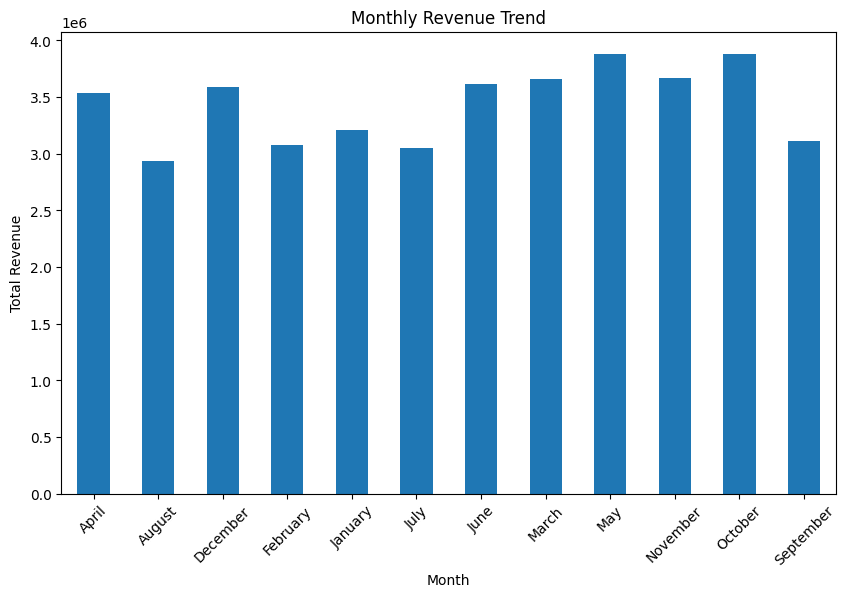

In [342]:
plt.figure(figsize=(10, 6))
df_sampled1.groupby('pickup_month')['Total_amount'].sum().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [343]:
df_sampled1['year'] = df_sampled1['tpep_pickup_datetime'].dt.year

In [344]:
# Calculate proportion of each quarter

df_sampled1['quarter'] = df_sampled1['tpep_pickup_datetime'].dt.quarter
df_sampled1.groupby('quarter')['Total_amount'].sum()

quarter
1     9950508.11
2    11026594.40
3     9104780.51
4    11141573.93
Name: Total_amount, dtype: float64

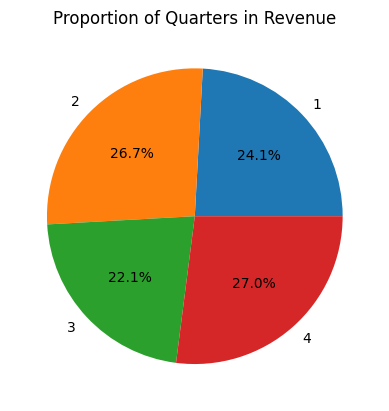

In [345]:
df_sampled1.groupby('quarter')['Total_amount'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Quarters in Revenue')
plt.ylabel('')
plt.show()

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [346]:
corr_matrix = df_sampled1[['trip_distance', 'fare_amount']].corr()
corr_matrix

trip_distance  fare_amount
trip_distance       1.000000     0.948885
fare_amount         0.948885     1.000000

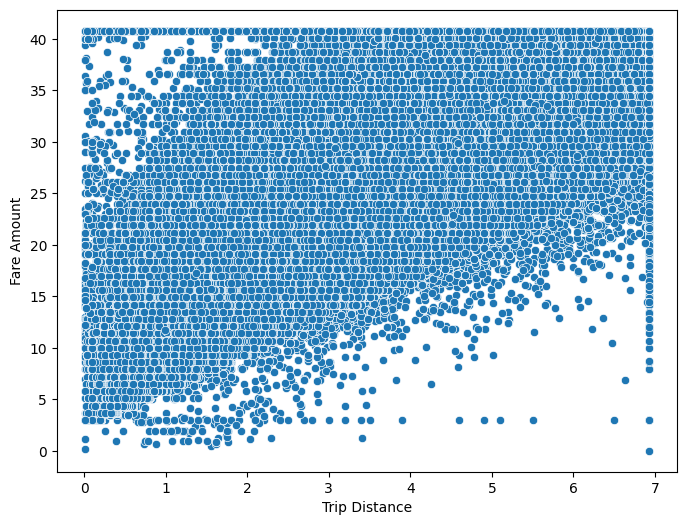

In [347]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sampled1, x='trip_distance', y='fare_amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

In [348]:
# Show how trip fare is affected by distance
df_sampled1.groupby('trip_distance')['fare_amount'].mean()



trip_distance
0.010    29.151689
0.020    25.439701
0.030    25.848500
0.040    27.856364
0.050    26.020400
           ...    
6.890    33.006316
6.900    32.561546
6.910    33.195455
6.920    32.764713
6.925    39.488794
Name: fare_amount, Length: 693, dtype: float64

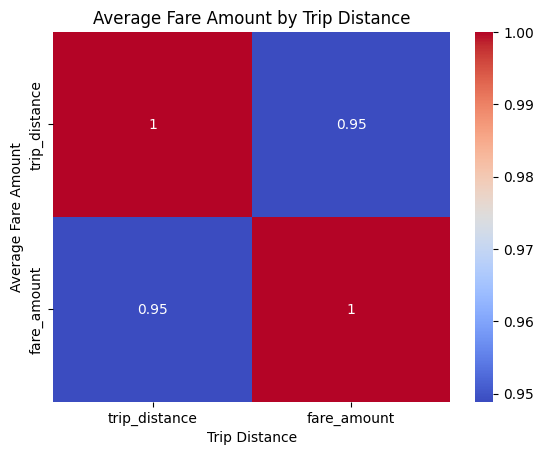

In [349]:
sns.heatmap(data = corr_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Trip Distance')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Trip Distance')
plt.show()

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [350]:
df_sampled1['trip_duration'] = (df_sampled1['tpep_dropoff_datetime'] - df_sampled1['tpep_pickup_datetime']).dt.total_seconds() / 60

In [351]:
df_sampled1.trip_duration.value_counts()

trip_duration
9.000000       1783
8.000000       1757
7.000000       1722
11.000000      1688
10.000000      1663
               ... 
115.516667        1
1393.116667       1
114.316667        1
125.750000        1
95.750000         1
Name: count, Length: 7167, dtype: int64

In [352]:
corr_matrix1 = df_sampled1[['fare_amount', 'trip_duration']].corr()
corr_matrix1


fare_amount  trip_duration
fare_amount       1.000000       0.331655
trip_duration     0.331655       1.000000

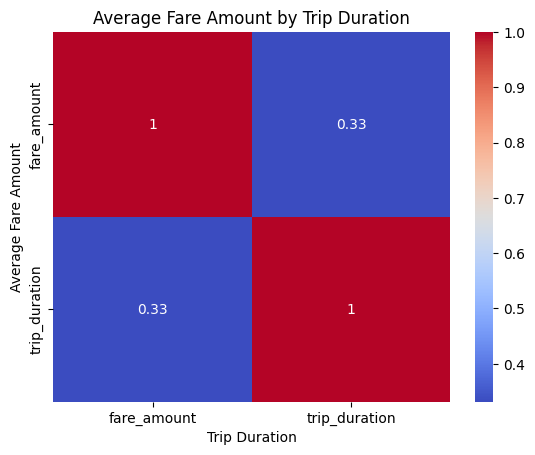

In [353]:
# Show relationship between fare and trip duration
sns.heatmap(data= corr_matrix1 , annot=True, cmap='coolwarm')
plt.xlabel('Trip Duration')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Trip Duration')
plt.show()


In [354]:
corr_matrix2 = df_sampled1[['fare_amount', 'passenger_count']].corr()
corr_matrix2


fare_amount  passenger_count
fare_amount              1.0              NaN
passenger_count          NaN              NaN

In [355]:
df_sampled1.passenger_count.isna().sum()

np.int64(0)

In [356]:
# Show relationship between fare and number of passengers

df_sampled1.groupby('passenger_count')['fare_amount'].mean()

passenger_count
1.0    17.312172
Name: fare_amount, dtype: float64

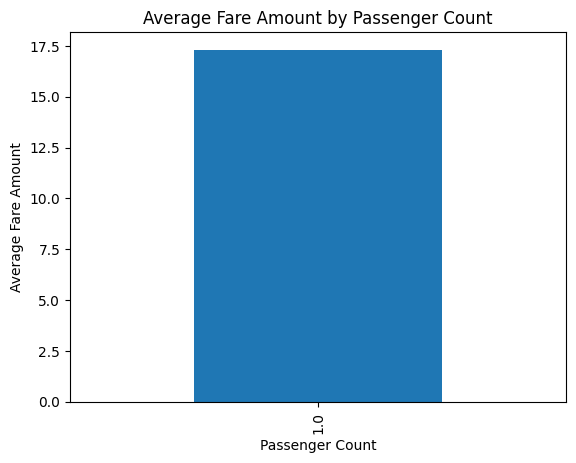

In [357]:
df_sampled1.groupby('passenger_count')['fare_amount'].mean().plot(kind='bar')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Passenger Count')
plt.show()

In [358]:
corr_matrix3 = df_sampled1[['tip_amount', 'trip_distance']].corr()
corr_matrix3

tip_amount  trip_distance
tip_amount       1.000000       0.800317
trip_distance    0.800317       1.000000

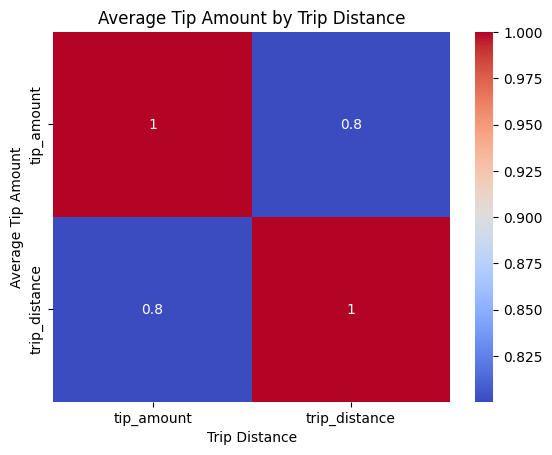

In [359]:
# Show relationship between tip and trip distance

sns.heatmap(data=corr_matrix3, annot=True, cmap='coolwarm')
plt.xlabel('Trip Distance')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount by Trip Distance')
plt.show()

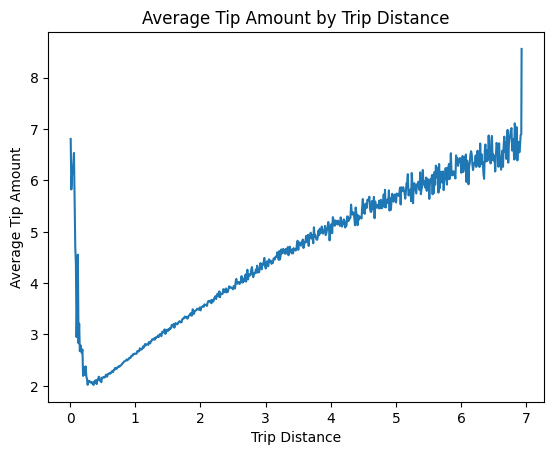

In [360]:
df_sampled1.groupby('trip_distance')['tip_amount'].mean().plot(kind='line')
plt.xlabel('Trip Distance')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount by Trip Distance')
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [361]:
# Analyse the distribution of different payment types (payment_type).

df_sampled1.groupby('payment_type')['fare_amount'].mean()


payment_type
1.0    17.312172
Name: fare_amount, dtype: float64

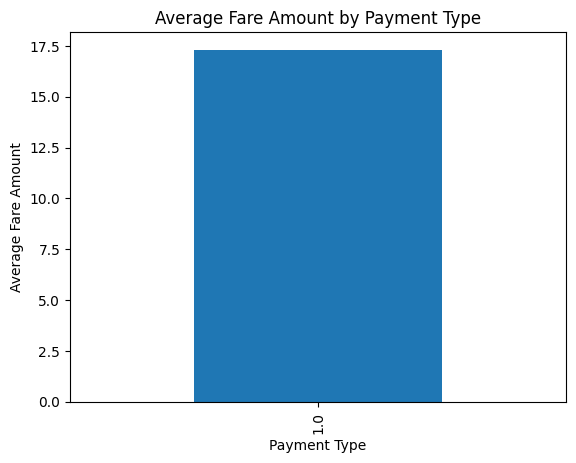

In [362]:
df_sampled1.groupby('payment_type')['fare_amount'].mean().plot(kind='bar')
plt.xlabel('Payment Type')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Payment Type')
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [363]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [364]:
#from google.colab import drive
#drive.mount('/content/drive')

In [365]:
import geopandas as gpd
zones = gpd.read_file('/content/drive/MyDrive/taxi_zones')
zones.head()


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

In [366]:
zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


In [367]:
zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB


In [368]:
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [369]:
 print(zones.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

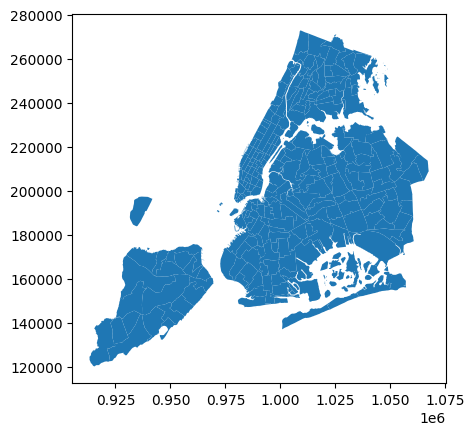

In [370]:
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [371]:
df_sampled1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'te', 'th', 'Extra', 'Mta_tax',
       'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge',
       'Airport_fEE_', 'AIrport_Fee', 'pickup_day', 'pickup_month', 'year',
       'quarter', 'trip_duration'],
      dtype='object')

In [372]:
zones.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry'],
      dtype='object')

In [373]:
# Merge zones and trip records using locationID and PULocationID

merge_zones=pd.merge(df_sampled1, zones, left_on='PULocationID', right_on='LocationID', how='left')
merge_zones

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0             2.0  2023-01-01 00:16:41   2023-01-01 00:21:46              1.0   
1             2.0  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   
2             1.0  2023-01-01 00:42:56   2023-01-01 01:16:33              1.0   
3             2.0  2023-01-01 00:58:00   2023-01-01 01:08:31              1.0   
4             2.0  2023-01-01 00:16:06   2023-01-01 00:31:59              1.0   
...           ...                  ...                   ...              ...   
1612221       2.0  2023-12-31 23:31:33   2023-12-31 23:52:27              1.0   
1612222       1.0  2023-12-31 23:06:14   2023-12-31 23:29:47              1.0   
1612223       2.0  2023-12-31 23:16:11   2023-12-31 23:56:35              1.0   
1612224       2.0  2023-12-31 23:16:11   2023-12-31 23:56:35              1.0   
1612225       2.0  2023-12-31 23:37:20   2023-12-31 23:41:18              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
0                1.240         1.0                  N         161.0   
1                6.925         1.0                  N          66.0   
2                6.925         1.0                  N         246.0   
3                1.590         1.0                  N          79.0   
4                3.160         1.0                  N          79.0   
...                ...         ...                ...           ...   
1612221          4.790         1.0                  N          90.0   
1612222          6.925         1.0                  N         141.0   
1612223          5.520         1.0                  N         158.0   
1612224          5.520         1.0                  N         158.0   
1612225          1.060         1.0                  N          79.0   

         DOLocationID  payment_type  ...  year  quarter  trip_duration  \
0               237.0           1.0  ...  2023        1       5.083333   
1               107.0           1.0  ...  2023        1      18.000000   
2                37.0           1.0  ...  2023        1      33.616667   
3               164.0           1.0  ...  2023        1      10.516667   
4               256.0           1.0  ...  2023        1      15.883333   
...               ...           ...  ...   ...      ...            ...   
1612221          25.0           1.0  ...  2023        4      20.900000   
1612222          95.0           1.0  ...  2023        4      23.550000   
1612223         151.0           1.0  ...  2023        4      40.400000   
1612224         151.0           1.0  ...  2023        4      40.400000   
1612225         137.0           1.0  ...  2023        4       3.966667   

        OBJECTID  Shape_Leng  Shape_Area                           zone  \
0          161.0    0.035804    0.000072                 Midtown Center   
1           66.0    0.054633    0.000108             DUMBO/Vinegar Hill   
2          246.0    0.069467    0.000281      West Chelsea/Hudson Yards   
3           79.0    0.042625    0.000108                   East Village   
4           79.0    0.042625    0.000108                   East Village   
...          ...         ...         ...                            ...   
1612221     90.0    0.030759    0.000055                       Flatiron   
1612222    141.0    0.041514    0.000077                Lenox Hill West   
1612223    158.0    0.054810    0.000186  Meatpacking/West Village West   
1612224    158.0    0.054810    0.000186  Meatpacking/West Village West   
1612225     79.0    0.042625    0.000108                   East Village   

         LocationID    borough  \
0             161.0  Manhattan   
1              66.0   Brooklyn   
2             246.0  Manhattan   
3              79.0  Manhattan   
4              79.0  Manhattan   
...             ...        ...   
1612221        90.0  Manhattan   
1612222       141.0  Manhattan   
1612223       158.0  Manhattan   
1612224       158.0  Manhattan   
1612225        79.0

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [374]:
# Group data by location and calculate the number of trips
merge_zones.groupby('LocationID')['PULocationID'].count()


LocationID
1.0         41
2.0          2
4.0       1885
6.0          1
7.0        420
         ...  
259.0        1
260.0      115
261.0     7887
262.0    22730
263.0    32144
Name: PULocationID, Length: 232, dtype: int64

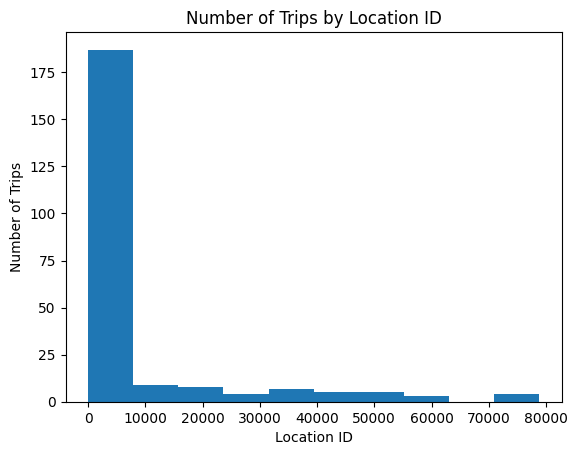

In [375]:
merge_zones.groupby('LocationID')['PULocationID'].count().plot(kind='hist')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Location ID')
plt.show()

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [376]:
# Merge trip counts back to the zones GeoDataFrame

merge_trip = pd.merge(zones, merge_zones.groupby('LocationID')['PULocationID'].count(), left_on='LocationID', right_index=True, how='left')
merge_trip.head()


OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   PULocationID  
0          41.0  
1           2.0  
2           NaN  
3        1885.0  
4           NaN

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

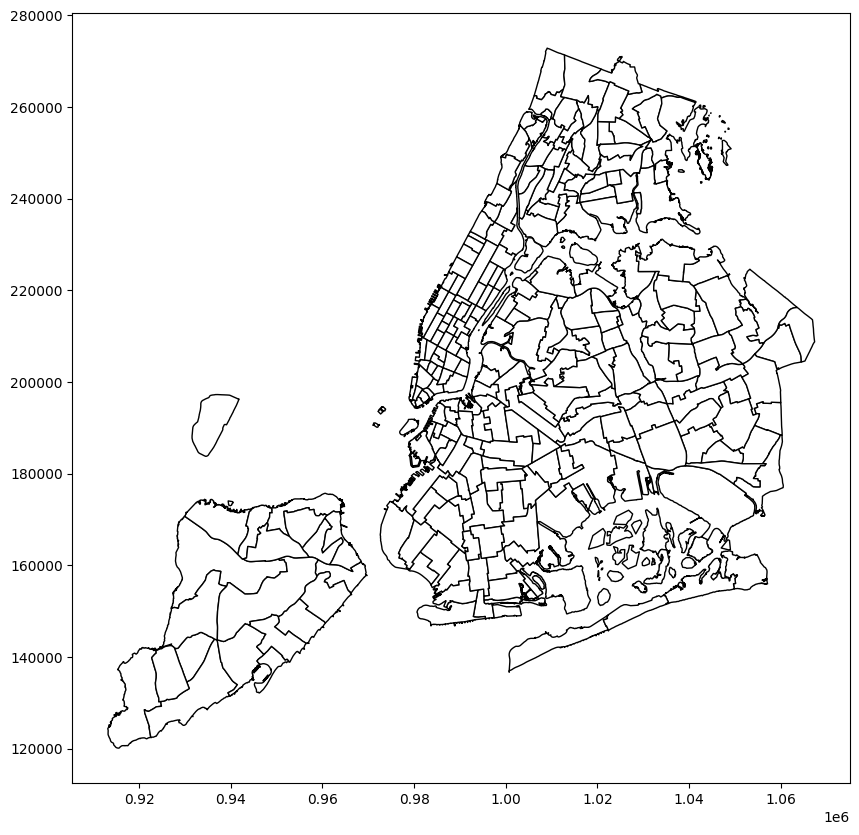

In [377]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
zones.plot(ax = ax, color = 'white', edgecolor = 'black')
plt.show()

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [378]:
zones.plot(ax = ax, color = 'white', edgecolor = 'black')

<Axes: >

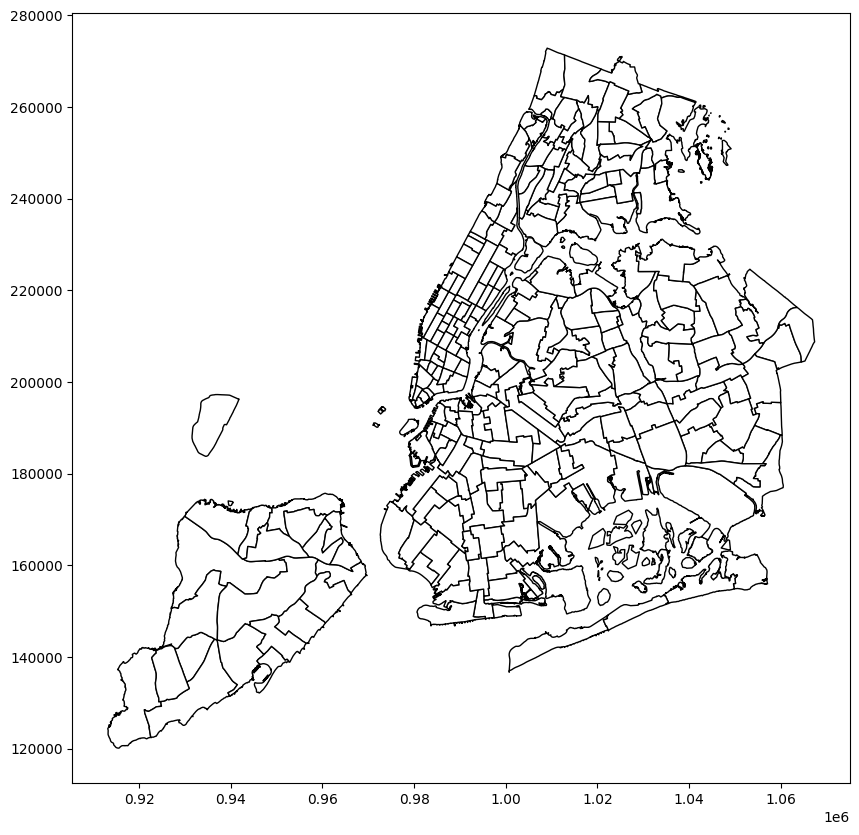

In [379]:
# Define figure and axis

fig, ax = plt.subplots(1, 1, figsize = (12, 10))
zones.plot(ax = ax, color = 'white', edgecolor = 'black')
plt.show()
# Plot the map and display it



In [380]:
# can you try displaying the zones DF sorted by the number of trips?

trip_sort = merge_trip.sort_values(by='PULocationID', ascending=False)
trip_sort

OBJECTID  Shape_Leng  Shape_Area                       zone  LocationID  \
236       237    0.042213    0.000096      Upper East Side South         237   
160       161    0.035804    0.000072             Midtown Center         161   
235       236    0.044252    0.000103      Upper East Side North         236   
131       132    0.245479    0.002038                JFK Airport         132   
161       162    0.035270    0.000048               Midtown East         162   
..        ...         ...         ...                        ...         ...   
203       204    0.101912    0.000641          Rossville/Woodrow         204   
205       206    0.212757    0.000944  Saint George/New Brighton         206   
213       214    0.135300    0.000812   South Beach/Dongan Hills         214   
220       221    0.166218    0.000890                  Stapleton         221   
244       245    0.095983    0.000466              West Brighton         245   

           borough                                           geometry  \
236      Manhattan  POLYGON ((993633.442 216961.016, 993507.232 21...   
160      Manhattan  POLYGON ((991081.026 214453.698, 990952.644 21...   
235      Manhattan  POLYGON ((995940.048 221122.92, 995812.322 220...   
131         Queens  MULTIPOLYGON (((1032791.001 181085.006, 103283...   
161      Manhattan  POLYGON ((992224.354 214415.293, 992096.999 21...   
..             ...                                                ...   
203  Staten Island  POLYGON ((927766.539 141772.465, 927864.475 14...   
205  Staten Island  POLYGON ((961436.305 175473.03, 961460.942 175...   
213  Staten Island  POLYGON ((960669.201 156319.132, 960902.551 15...   
220  Staten Island  POLYGON ((963349.728 171627.581, 963397.759 17...   
244  Staten Island  POLYGON ((957085.564 172591.26, 957142.385 172...   

     PULocationID  
236       78804.0  
160       76004.0  
235       72570.0  
131       71131.0  
161       59306.0  
..            ...  
203           NaN  
205           NaN  
213           NaN  
220           NaN  
244           NaN  

[263 rows x 8 columns]

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [381]:
# Find routes which have the slowest speeds at different times of the day
routes = df_sampled1.groupby(['PULocationID','DOLocationID'])['trip_duration'].mean()
routes
average_duration =df_sampled1.groupby(df_sampled1['tpep_pickup_datetime'].dt.hour)['trip_duration'].mean()
average_duration

tpep_pickup_datetime
0     15.019483
1     14.104178
2     12.981309
3     12.711988
4     15.189593
5     15.887305
6     15.075724
7     14.995625
8     15.849165
9     16.249415
10    16.990464
11    17.047279
12    17.446351
13    18.445794
14    19.823832
15    20.070225
16    20.132812
17    18.467812
18    16.609052
19    15.461936
20    15.767212
21    15.302148
22    15.661950
23    16.035407
Name: trip_duration, dtype: float64

In [382]:
routes

PULocationID  DOLocationID
1.0           1.0              1.066667
              87.0            41.366667
              138.0           34.333333
              170.0           31.183333
              237.0           74.766667
                                ...    
265.0         250.0           14.333333
              252.0           31.666667
              261.0           54.533333
              264.0            0.044444
              265.0            7.306061
Name: trip_duration, Length: 13120, dtype: float64

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [383]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour = df_sampled1.groupby(df_sampled1['tpep_pickup_datetime'].dt.hour)['PULocationID'].count()
trips_per_hour

tpep_pickup_datetime
0      45697
1      30555
2      19625
3      12390
4       7626
5       8107
6      20820
7      44135
8      62670
9      68985
10     72444
11     78534
12     85314
13     87258
14     94329
15     97451
16     98702
17    110420
18    117566
19    105337
20     94277
21     94849
22     87555
23     67542
Name: PULocationID, dtype: int64

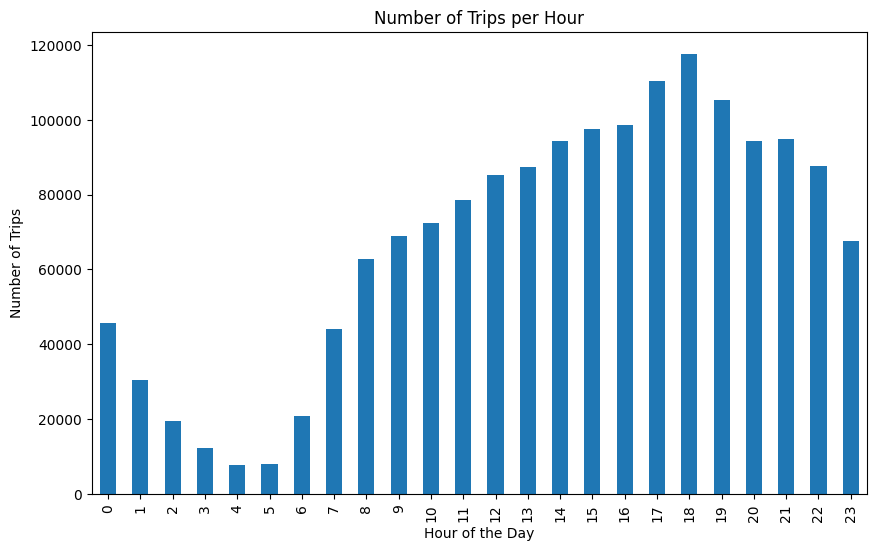

In [384]:
plt.figure(figsize=(10, 6))
trips_per_hour.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Hour')
plt.show()

In [385]:
busiest_hour = trips_per_hour.idxmax()
busiest_hour

np.int32(18)

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [386]:
trips_per_hour.sort_values(ascending=False).head()

tpep_pickup_datetime
18    117566
17    110420
19    105337
16     98702
15     97451
Name: PULocationID, dtype: int64

In [387]:
# Scale up the number of trips
# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05

trips_scale_up = trips_per_hour * sample_fraction
trips_scale_up



tpep_pickup_datetime
0     2284.85
1     1527.75
2      981.25
3      619.50
4      381.30
5      405.35
6     1041.00
7     2206.75
8     3133.50
9     3449.25
10    3622.20
11    3926.70
12    4265.70
13    4362.90
14    4716.45
15    4872.55
16    4935.10
17    5521.00
18    5878.30
19    5266.85
20    4713.85
21    4742.45
22    4377.75
23    3377.10
Name: PULocationID, dtype: float64

In [388]:
trips_scale_up.sort_values(ascending=False).head()

tpep_pickup_datetime
18    5878.30
17    5521.00
19    5266.85
16    4935.10
15    4872.55
Name: PULocationID, dtype: float64

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [389]:
# Compare traffic trends for the week days and weekends
df_sampled1['day_of_week'] = df_sampled1['tpep_pickup_datetime'].dt.dayofweek
df_sampled1.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1       2.0  2023-01-01 00:16:41   2023-01-01 00:21:46              1.0   
4       2.0  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   
5       1.0  2023-01-01 00:42:56   2023-01-01 01:16:33              1.0   
6       2.0  2023-01-01 00:58:00   2023-01-01 01:08:31              1.0   
7       2.0  2023-01-01 00:16:06   2023-01-01 00:31:59              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
1          1.240         1.0                  N         161.0         237.0   
4          6.925         1.0                  N          66.0         107.0   
5          6.925         1.0                  N         246.0          37.0   
6          1.590         1.0                  N          79.0         164.0   
7          3.160         1.0                  N          79.0         256.0   

   payment_type  ...  Total_amount  Congestion_surcharge  Airport_fEE_  \
1           1.0  ...         15.48                   2.5           0.0   
4           1.0  ...         35.57                   2.5           0.0   
5           1.0  ...         47.40                   2.5           0.0   
6           1.0  ...         19.68                   2.5           0.0   
7           1.0  ...         30.12                   2.5           0.0   

  AIrport_Fee  pickup_day  pickup_month  year  quarter  trip_duration  \
1         0.0      Sunday       January  2023        1       5.083333   
4         0.0      Sunday       January  2023        1      18.000000   
5         0.0      Sunday       January  2023        1      33.616667   
6         0.0      Sunday       January  2023        1      10.516667   
7         0.0      Sunday       January  2023        1      15.883333   

   day_of_week  
1            6  
4            6  
5            6  
6            6  
7            6  

[5 rows x 28 columns]

In [390]:
df_sampled1.groupby(df_sampled1['day_of_week']<6).count()

VendorID  tpep_pickup_datetime  tpep_dropoff_datetime  \
day_of_week                                                          
False          199359                199359                 199359   
True          1412829               1412829                1412829   

             passenger_count  trip_distance  RatecodeID  store_and_fwd_flag  \
day_of_week                                                                   
False                 199359         199359      199359              199359   
True                 1412829        1412829     1412829             1412829   

             PULocationID  DOLocationID  payment_type  ...  Total_amount  \
day_of_week                                            ...                 
False              199359        199359        199359  ...        199359   
True              1412829       1412829       1412829  ...       1412829   

             Congestion_surcharge  Airport_fEE_  AIrport_Fee  pickup_day  \
day_of_week                                                                
False                      199359        199359       199359      199359   
True                      1412829       1412829      1412829     1412829   

             pickup_month     year  quarter  trip_duration  day_of_week  
day_of_week                                                              
False              199359   199359   199359         199359       199359  
True              1412829  1412829  1412829        1412829      1412829  

[2 rows x 28 columns]

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [391]:
# Find top 10 pickup and dropoff zones
Top_10_pickup_location = df_sampled1.groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False).head(10)
print(Top_10_pickup_location)
Top_10_dropoff_location = df_sampled1.groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False).head(10)
Top_10_dropoff_location

PULocationID
237.0    78804
161.0    76004
236.0    72570
132.0    71131
162.0    59306
138.0    57611
142.0    55493
186.0    54655
230.0    50093
170.0    48904
Name: PULocationID, dtype: int64


DOLocationID
236.0    76781
237.0    70808
161.0    62975
170.0    49045
239.0    48618
142.0    47265
162.0    46978
141.0    45268
230.0    44817
68.0     41121
Name: DOLocationID, dtype: int64

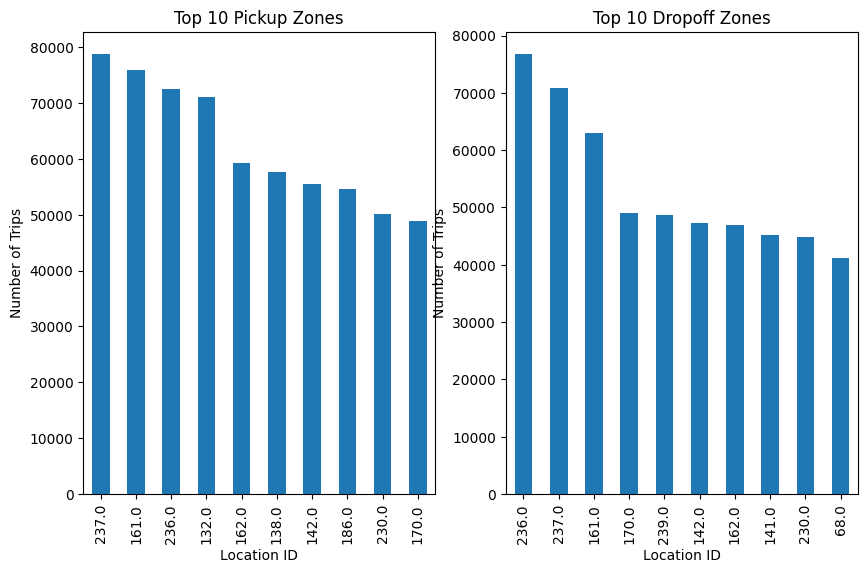

In [392]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
Top_10_pickup_location.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.title('Top 10 Pickup Zones')
plt.subplot(1, 2, 2)
Top_10_dropoff_location.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.title('Top 10 Dropoff Zones')
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [393]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_dropoff_ratio = df_sampled1.groupby('PULocationID')['PULocationID'].count() / df_sampled1.groupby('DOLocationID')['DOLocationID'].count()
pickup_dropoff_ratio

top_10_pickup_dropoff_ratio = pickup_dropoff_ratio.sort_values(ascending=False).head(10)
bottom_10_pickup_dropoff_ratio = pickup_dropoff_ratio.sort_values(ascending=False).tail(10)
print(top_10_pickup_dropoff_ratio)
print()
print()
print(bottom_10_pickup_dropoff_ratio)

70.0     13.081374
132.0     4.251449
138.0     2.576751
207.0     2.000000
186.0     1.638978
114.0     1.386107
43.0      1.384754
249.0     1.335610
162.0     1.262421
215.0     1.236842
dtype: float64


176.0   NaN
183.0   NaN
187.0   NaN
199.0   NaN
201.0   NaN
204.0   NaN
206.0   NaN
214.0   NaN
221.0   NaN
245.0   NaN
dtype: float64


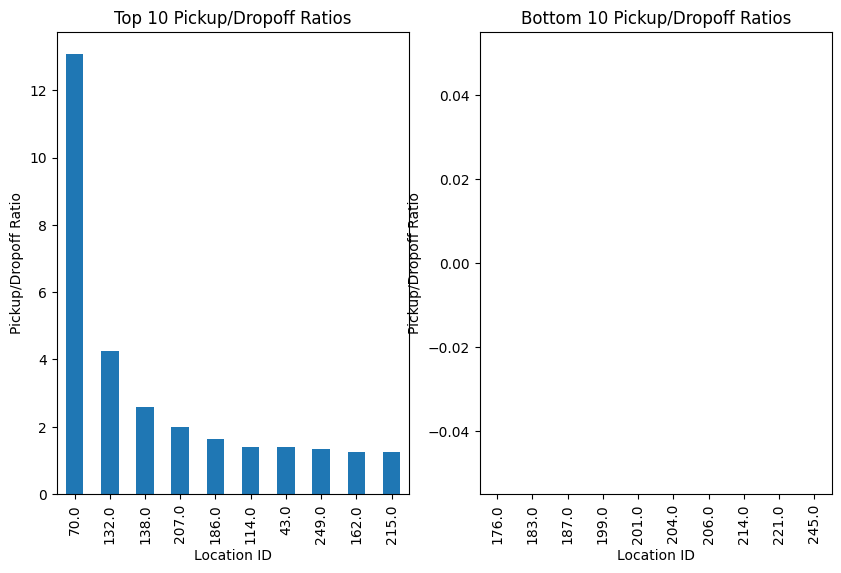

In [394]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
top_10_pickup_dropoff_ratio.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Pickup/Dropoff Ratio')
plt.title('Top 10 Pickup/Dropoff Ratios')
plt.subplot(1, 2, 2)
bottom_10_pickup_dropoff_ratio.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Pickup/Dropoff Ratio')
plt.title('Bottom 10 Pickup/Dropoff Ratios')
plt.show()

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [395]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
df_sampled1['night_hours'] = (df_sampled1['tpep_pickup_datetime'].dt.hour >= 23) | (df_sampled1['tpep_pickup_datetime'].dt.hour <= 5)

# Use the 'night_hours' column for filtering:
top_10_pickup_location_night = df_sampled1[df_sampled1['night_hours']].groupby('PULocationID')['PULocationID'].count().sort_values(ascending=False).head(10)
top_10_dropoff_location_night = df_sampled1[df_sampled1['night_hours']].groupby('DOLocationID')['DOLocationID'].count().sort_values(ascending=False).head(10)

print(top_10_pickup_location_night)
print()
print()
print(top_10_dropoff_location_night)

PULocationID
79.0     14634
249.0    11943
132.0    10652
148.0     9196
48.0      9144
114.0     8310
230.0     6654
186.0     6073
164.0     5503
68.0      5367
Name: PULocationID, dtype: int64


DOLocationID
79.0     7660
48.0     5831
170.0    5717
107.0    5451
141.0    5142
68.0     5121
263.0    4948
249.0    4668
239.0    4318
236.0    4201
Name: DOLocationID, dtype: int64


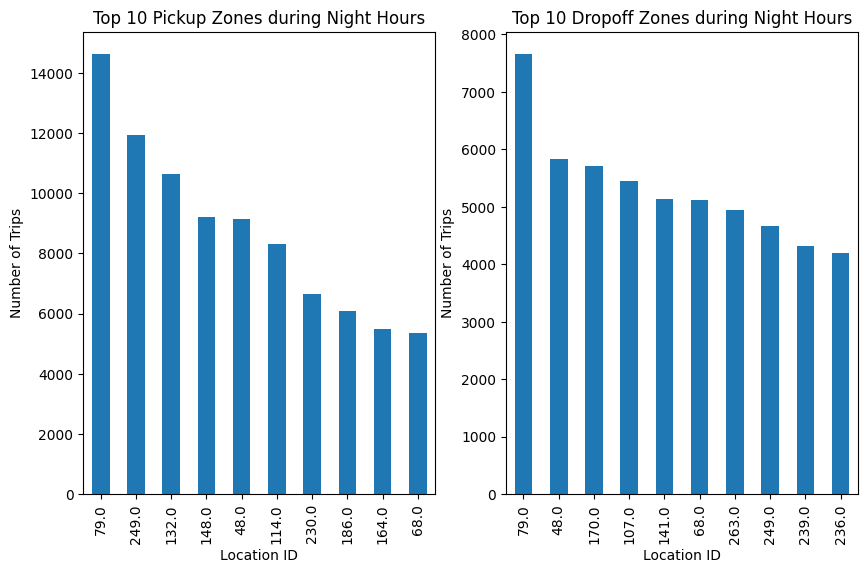

In [396]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
top_10_pickup_location_night.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.title('Top 10 Pickup Zones during Night Hours')
plt.subplot(1,2,2)
top_10_dropoff_location_night.plot(kind='bar')
plt.xlabel('Location ID')
plt.ylabel('Number of Trips')
plt.title('Top 10 Dropoff Zones during Night Hours')
plt.show()

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [397]:
# Filter for night hours (11 PM to 5 AM)
df_sampled1.groupby(['night_hours']).fare_amount.sum()

night_hours
False    24510457.72
True      3400018.15
Name: fare_amount, dtype: float64

Text(0, 0.5, 'Revenue')

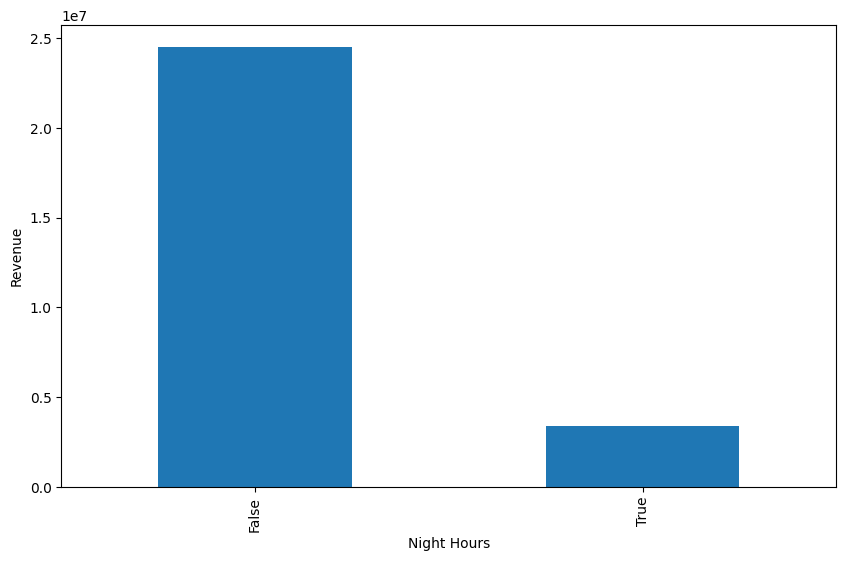

In [398]:
plt.figure(figsize=(10, 6))
df_sampled1.groupby(['night_hours']).fare_amount.sum().plot(kind='bar')
plt.xlabel('Night Hours')
plt.ylabel('Revenue')

In [399]:
df_sampled1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'te', 'th', 'Extra', 'Mta_tax',
       'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge',
       'Airport_fEE_', 'AIrport_Fee', 'pickup_day', 'pickup_month', 'year',
       'quarter', 'trip_duration', 'day_of_week', 'night_hours'],
      dtype='object')

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [400]:
# Analyse the fare per mile per passenger for different passenger counts
fare_per_mile_per_passenger = df_sampled1.groupby('passenger_count')['fare_amount'].sum() / df_sampled1.groupby('passenger_count')['trip_distance'].sum()
fare_per_mile_per_passenger


passenger_count
1.0    6.588973
dtype: float64

**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [401]:
df_sampled1.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'te', 'th', 'Extra', 'Mta_tax',
       'Improvement_surcharge', 'Total_amount', 'Congestion_surcharge',
       'Airport_fEE_', 'AIrport_Fee', 'pickup_day', 'pickup_month', 'year',
       'quarter', 'trip_duration', 'day_of_week', 'night_hours'],
      dtype='object')

In [402]:
# Compare the average fare per mile for different days and for different times of the day
average_fare_per_mile_for_different_days = df_sampled1.groupby(['day_of_week']).fare_amount.sum()/df_sampled1.groupby(['day_of_week']).trip_distance.sum()
average_fare_per_mile_for_different_times = df_sampled1.groupby(['th']).fare_amount.sum()/df_sampled1.groupby(['th']).trip_distance.sum()
print(average_fare_per_mile_for_different_days)
print()
print()
print(average_fare_per_mile_for_different_times)

day_of_week
0    6.395954
1    6.741607
2    6.803246
3    6.793135
4    6.621113
5    6.526367
6    6.169159
dtype: float64


th
0     5.837620
1     5.734961
2     5.626255
3     5.557894
4     5.507675
5     5.697140
6     5.792596
7     6.193282
8     6.624932
9     6.766687
10    6.833869
11    7.012431
12    7.055304
13    6.987680
14    6.980961
15    7.036707
16    7.006199
17    7.037122
18    6.911688
19    6.607134
20    6.286485
21    6.159341
22    6.080824
23    5.942004
dtype: float64


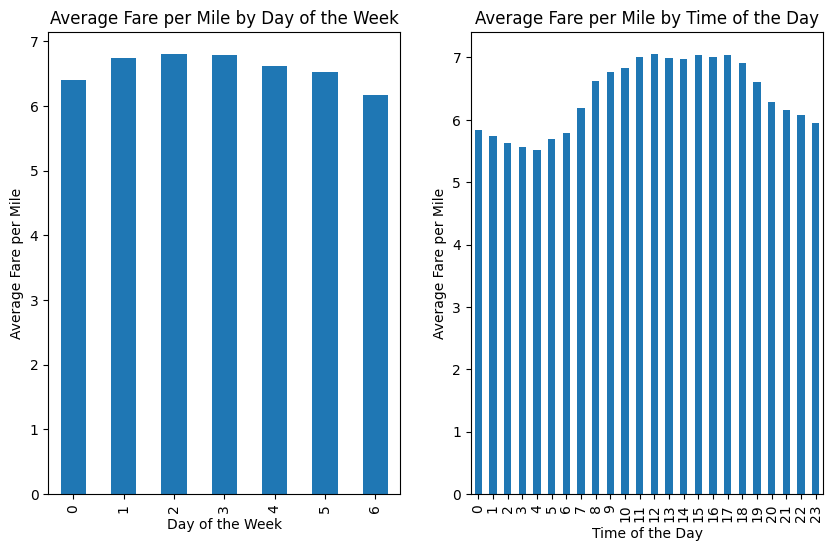

In [403]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
average_fare_per_mile_for_different_days.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Day of the Week')
plt.subplot(1,2,2)
average_fare_per_mile_for_different_times.plot(kind='bar')
plt.xlabel('Time of the Day')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Time of the Day')
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [404]:
# Compare fare per mile for different vendors
average_fare_per_mile_for_different_vendors = df_sampled1.groupby(['VendorID']).fare_amount.sum()/df_sampled1.groupby(['VendorID']).trip_distance.sum()
average_fare_per_mile_for_different_vendors

VendorID
1.0    6.603996
2.0    6.584214
dtype: float64

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [405]:
# Defining distance tiers
df_sampled1['distance_tier'] = pd.cut(df_sampled1['trip_distance'], bins=[0, 2, 5, float('inf')], labels=['0-2 miles', '2-5 miles', '5+ miles'])


In [406]:
df_sampled1.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1       2.0  2023-01-01 00:16:41   2023-01-01 00:21:46              1.0   
4       2.0  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   
5       1.0  2023-01-01 00:42:56   2023-01-01 01:16:33              1.0   
6       2.0  2023-01-01 00:58:00   2023-01-01 01:08:31              1.0   
7       2.0  2023-01-01 00:16:06   2023-01-01 00:31:59              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
1          1.240         1.0                  N         161.0         237.0   
4          6.925         1.0                  N          66.0         107.0   
5          6.925         1.0                  N         246.0          37.0   
6          1.590         1.0                  N          79.0         164.0   
7          3.160         1.0                  N          79.0         256.0   

   payment_type  ...  Airport_fEE_  AIrport_Fee  pickup_day pickup_month  \
1           1.0  ...           0.0          0.0      Sunday      January   
4           1.0  ...           0.0          0.0      Sunday      January   
5           1.0  ...           0.0          0.0      Sunday      January   
6           1.0  ...           0.0          0.0      Sunday      January   
7           1.0  ...           0.0          0.0      Sunday      January   

   year  quarter  trip_duration  day_of_week  night_hours  distance_tier  
1  2023        1       5.083333            6         True      0-2 miles  
4  2023        1      18.000000            6         True       5+ miles  
5  2023        1      33.616667            6         True       5+ miles  
6  2023        1      10.516667            6         True      0-2 miles  
7  2023        1      15.883333            6         True      2-5 miles  

[5 rows x 30 columns]

In [407]:
average_fare_distance_tier = df_sampled1.groupby(['VendorID','distance_tier']).fare_amount.sum()/df_sampled1.groupby(['VendorID','distance_tier']).trip_distance.sum()
average_fare_distance_tier

<ipython-input-407-a90eac72a778>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_fare_distance_tier = df_sampled1.groupby(['VendorID','distance_tier']).fare_amount.sum()/df_sampled1.groupby(['VendorID','distance_tier']).trip_distance.sum()


VendorID  distance_tier
1.0       0-2 miles        8.558225
          2-5 miles        6.226985
          5+ miles         5.541474
2.0       0-2 miles        8.732573
          2-5 miles        6.385660
          5+ miles         5.580415
dtype: float64

Text(0.5, 1.0, 'Average Fare per Mile by Distance Tier')

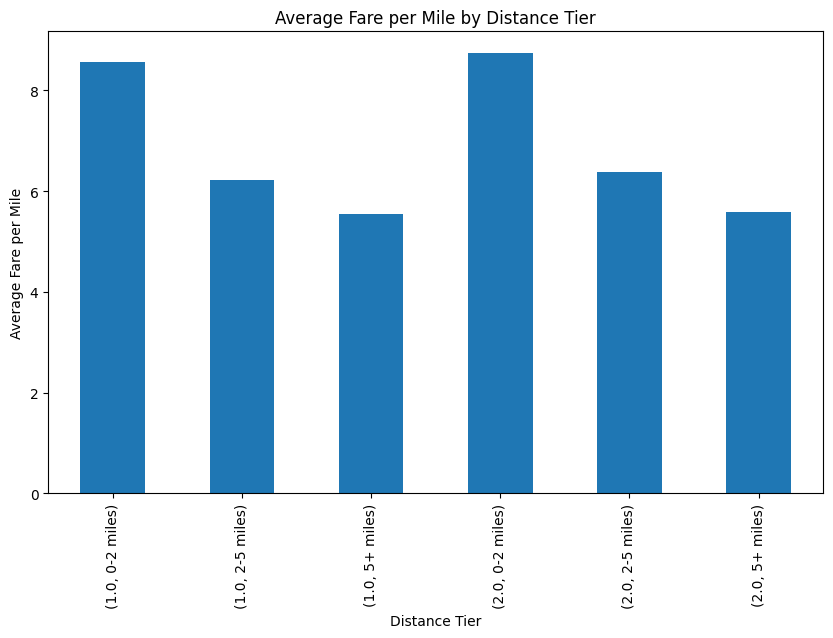

In [408]:
plt.figure(figsize=(10, 6))
average_fare_distance_tier.plot(kind='bar')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile')
plt.title('Average Fare per Mile by Distance Tier')

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [409]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df_sampled1['tip_percentage'] = df_sampled1['tip_amount'] / df_sampled1['fare_amount']
average_tip_percentage_distance = df_sampled1.groupby('trip_distance')['tip_percentage'].mean()
average_tip_percentage_passenger_count = df_sampled1.groupby('passenger_count')['tip_percentage'].mean()
average_tip_percentage_pickup_time = df_sampled1.groupby(df_sampled1['tpep_pickup_datetime'].dt.hour)['tip_percentage'].mean()
print(average_tip_percentage_distance)
print()
print()
print(average_tip_percentage_passenger_count)
print()
print()
print(average_tip_percentage_pickup_time)


trip_distance
0.010    0.463979
0.020    0.357176
0.030    0.379673
0.040    0.305827
0.050    0.390464
           ...   
6.890    0.198557
6.900    0.205456
6.910    0.208038
6.920    0.211237
6.925    0.221578
Name: tip_percentage, Length: 693, dtype: float64


passenger_count
1.0    0.258547
Name: tip_percentage, dtype: float64


tpep_pickup_datetime
0     0.255641
1     0.258325
2     0.260952
3     0.261237
4     0.257006
5     0.254703
6     0.246360
7     0.246698
8     0.246709
9     0.249712
10    0.252114
11    0.251823
12    0.251133
13    0.251177
14    0.249253
15    0.248162
16    0.267706
17    0.277912
18    0.272503
19    0.271904
20    0.262546
21    0.261056
22    0.257812
23    0.254823
Name: tip_percentage, dtype: float64


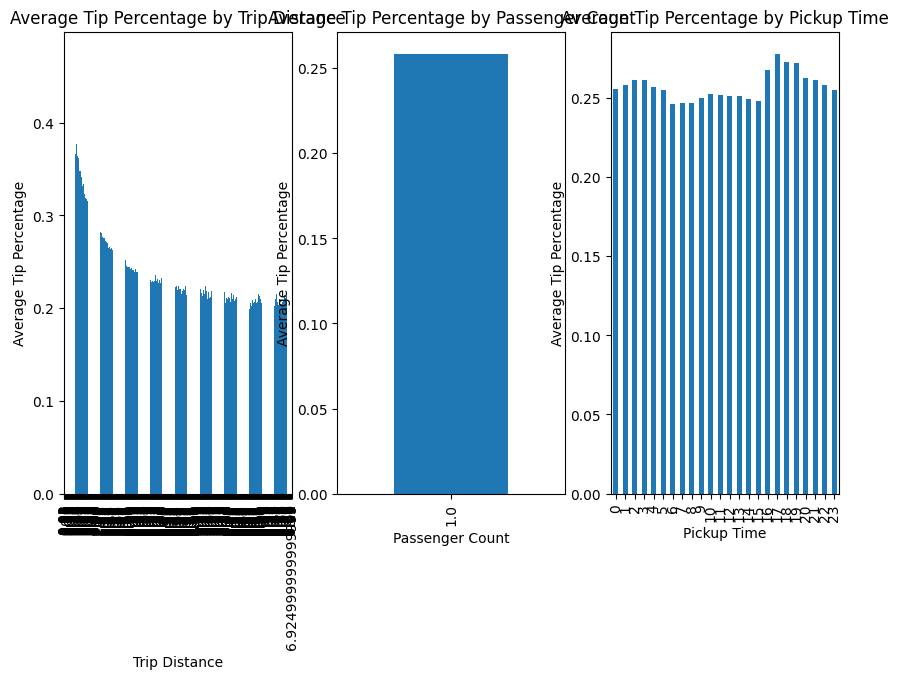

In [410]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
average_tip_percentage_distance.plot(kind='bar')
plt.xlabel('Trip Distance')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Trip Distance')
plt.subplot(1,3,2)
average_tip_percentage_passenger_count.plot(kind='bar')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Passenger Count')
plt.subplot(1,3,3)
average_tip_percentage_pickup_time.plot(kind='bar')
plt.xlabel('Pickup Time')
plt.ylabel('Average Tip Percentage')
plt.title('Average Tip Percentage by Pickup Time')
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [411]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
tip_10 = df_sampled1[df_sampled1['tip_percentage'] < 0.1]  # Filter based on tip_percentage
tip_25 = df_sampled1[df_sampled1['tip_percentage'] > 0.25] # Filter based on tip_percentage

# Now you can compare these two DataFrames (tip_10 and tip_25)
# For example, compare their  trip distances:
trip_distance_tip_10 = tip_10['trip_distance'].value_counts()
trip_distance_tip_25 = tip_25['trip_distance'].value_counts()

print(f" trip distance for tips < 10%: {trip_distance_tip_10}")
print(f" trip distance for tips > 25%: {trip_distance_tip_25}")


 trip distance for tips < 10%: trip_distance
6.925    9821
1.600     931
1.800     923
1.700     893
1.500     891
         ... 
0.190       4
0.250       4
0.060       3
0.230       3
0.260       2
Name: count, Length: 693, dtype: int64
 trip distance for tips > 25%: trip_distance
6.925    17269
0.900    17044
1.000    16878
0.800    16722
1.100    16363
         ...  
6.670       23
6.570       22
6.240       21
6.080       20
6.520       18
Name: count, Length: 693, dtype: int64


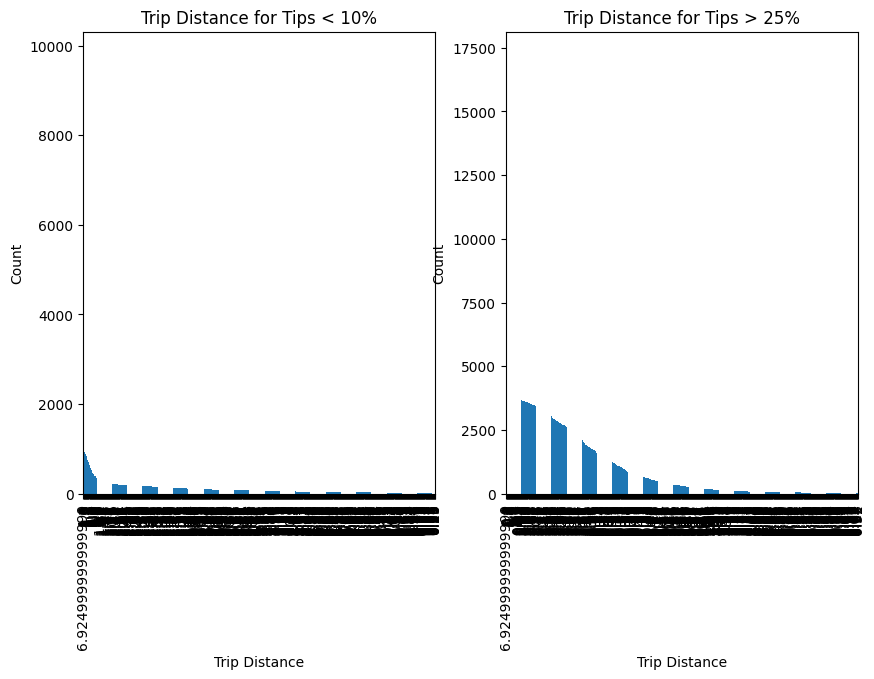

In [412]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
tip_10['trip_distance'].value_counts().plot(kind='bar')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.title('Trip Distance for Tips < 10%')
plt.subplot(1,2,2)
tip_25['trip_distance'].value_counts().plot(kind='bar')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.title('Trip Distance for Tips > 25%')
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [413]:
# See how passenger count varies across hours and days
passenger_count_by_hour = df_sampled1.groupby(df_sampled1['tpep_pickup_datetime'].dt.hour)['passenger_count'].mean()
passenger_count_by_day = df_sampled1.groupby(df_sampled1['tpep_pickup_datetime'].dt.dayofweek)['passenger_count'].mean()
print(passenger_count_by_hour)
print()
print()
print(passenger_count_by_day)


tpep_pickup_datetime
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
Name: passenger_count, dtype: float64


tpep_pickup_datetime
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
Name: passenger_count, dtype: float64


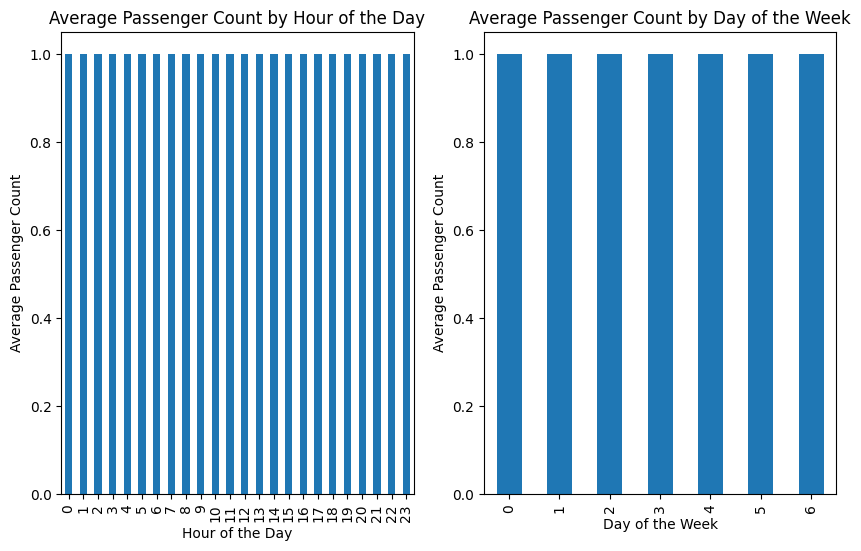

In [414]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
passenger_count_by_hour.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Passenger Count')
plt.title('Average Passenger Count by Hour of the Day')
plt.subplot(1,2,2)
passenger_count_by_day.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Average Passenger Count')
plt.title('Average Passenger Count by Day of the Week')
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [415]:
# How does passenger count vary across zones
passenger_count_by_zone = df_sampled1.groupby('PULocationID')['passenger_count'].mean()
passenger_count_by_zone


PULocationID
1.0      1.0
2.0      1.0
4.0      1.0
6.0      1.0
7.0      1.0
        ... 
261.0    1.0
262.0    1.0
263.0    1.0
264.0    1.0
265.0    1.0
Name: passenger_count, Length: 235, dtype: float64

In [416]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
zones['average_passenger_count'] = zones['LocationID'].map(passenger_count_by_zone)
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   average_passenger_count  
0                      1.0  
1                      1.0  
2                      NaN  
3                      1.0  
4                      NaN

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [417]:
# How often is each surcharge applied?
pickup_zone = df_sampled1.groupby('PULocationID')['Extra'].sum()
dropoff_zone = df_sampled1.groupby('DOLocationID')['Extra'].sum()
print(pickup_zone)
print()
print()
print(dropoff_zone)


PULocationID
1.0         10.50
2.0          0.00
4.0       2339.75
6.0          1.00
7.0        300.00
           ...   
261.0    11340.25
262.0    28008.45
263.0    43607.50
264.0    18154.25
265.0       92.25
Name: Extra, Length: 235, dtype: float64


DOLocationID
1.0       2389.75
3.0        129.50
4.0      10072.00
5.0          5.50
6.0         21.00
           ...   
261.0    11483.00
262.0    44823.22
263.0    57944.45
264.0    21160.25
265.0     7742.25
Name: Extra, Length: 258, dtype: float64


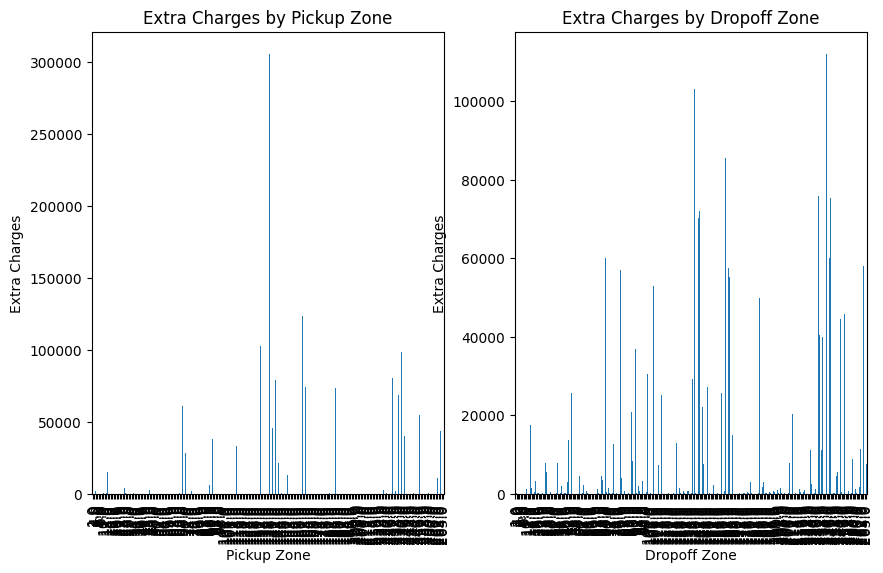

In [418]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
pickup_zone.plot(kind='bar')
plt.xlabel('Pickup Zone')
plt.ylabel('Extra Charges')
plt.title('Extra Charges by Pickup Zone')
plt.subplot(1,2,2)
dropoff_zone.plot(kind='bar')
plt.xlabel('Dropoff Zone')
plt.ylabel('Extra Charges')
plt.title('Extra Charges by Dropoff Zone')
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies



### 🚦 **Recommendations to Optimize Routing & Dispatching**

#### 1. **Time-Based Demand Routing**
- **Morning Peak (7–10 AM)** and **Evening Peak (4–7 PM)** see the highest ride volumes.
- Implement **time-aware dispatching systems** that push more drivers toward business districts (e.g., Midtown Manhattan) during commute hours.
- Reduce idle time by **pre-assigning** drivers to high-demand zones just before peak hours begin.

#### 2. **Zone Prioritization**
- Use ride frequency data to build **zone-level heatmaps**.
  - Prioritize dispatch in **Midtown, Downtown, Upper East/West Sides**, and **airport terminals**.
- Allocate drivers in **concentric coverage rings** around hot zones to enable quick redeployment based on surge.

#### 3. **Predictive Routing**
- Apply **machine learning models** (or even simple moving averages) on historical data to **forecast hourly demand** by zone and day.
- Dynamically **reroute idle taxis** from low-demand areas to predicted hotspots in advance.

#### 4. **Reduce Inefficient Trips**
- Flag and discourage **short, zero-distance trips** with high fares—often a sign of logging errors or inefficiencies.
- Identify **frequent deadhead routes** (where drivers return without passengers) and use them to suggest better repositioning.

#### 5. **Incorporate External Signals**
- Integrate **event calendars, weather data, and flight/train schedules** into dispatch logic to anticipate spikes.
  - E.g., deploy extra taxis near MSG during events or at airports during weather delays.

#### 6. **Smart Driver Guidance**
- Provide drivers with **real-time heatmaps**, route suggestions, and occupancy predictions via mobile apps or dashboards.
- Incentivize drivers to position themselves proactively in underserved but high-potential zones.


**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

Strategic Cab Positioning Recommendations by Time, Day & Zone
🕒 Time of Day
Morning Rush (6 AM – 10 AM):

Deploy in Residential Zones like Upper East/West Side, Brooklyn (Williamsburg, Park Slope), and Queens.

These areas show high pickup volumes as people commute to work.

Ensure cabs are available for airport-bound passengers early in the morning, especially from Midtown and Brooklyn.

Midday (10 AM – 3 PM):

Focus on Business & Tourist Districts: Midtown Manhattan, Times Square, Downtown/Financial District.

Increase coverage around hospitals, schools, and government buildings where midday travel is common.

Evening Rush (4 PM – 7 PM):

Position in Business Hubs and Airports: Ready pickups from corporate offices, Wall Street, and JFK/LGA for home-bound commuters.

Deploy cabs to transit stations like Grand Central and Penn Station to capture end-of-day travelers.

Late Evening/Night (7 PM – 12 AM):

Concentrate around restaurants, bars, and entertainment zones: Lower Manhattan, East Village, Williamsburg, Meatpacking District.

These zones show higher trip lengths and generous tipping.

📅 Day of the Week
Weekdays (Mon–Fri):

Prioritize commute-based travel patterns:

Morning: focus on pickups in outer boroughs.

Evening: focus on drop-offs in those same residential areas.

Deploy more cabs to office districts during lunch and early evening hours.

Weekends (Fri Night – Sunday):

Reposition fleet near nightlife and tourist areas Friday and Saturday nights (e.g., SoHo, Midtown, Harlem).

Airport pickups rise on Sundays, so boost presence around JFK and LaGuardia.

Expect higher group sizes; keep larger taxis (e.g., minivans) available.

📆 Monthly/Seasonal Trends
Summer (June – August):

Tourists flood Manhattan: scale up presence in Midtown, Central Park, and Battery Park areas.

Weekend trips to beaches (Far Rockaway, Coney Island) increase – deploy accordingly.

Holiday Season (Nov – Dec):

Demand spikes near shopping hubs and tourist landmarks (e.g., Fifth Avenue, Rockefeller Center).

Plan for increased trips to/from airports and transit stations.

Rainy/Cold Weather Days:

Demand for taxis rises due to reluctance to walk or bike – keep reserve fleet in weather-prone hot zones.

✅ Implementation Tips
Use real-time GPS + historical trip heatmaps to auto-adjust cab locations throughout the day.

Consider zonal shift-based assignments: assign drivers to zones with clear peak windows to avoid over-saturation.

Rotate driver coverage in low-demand zones periodically to maintain presence without idle time.


**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

💰 Proposed Data-Driven Pricing Strategy Adjustments
1. Time-Based Dynamic Pricing
Insight Used: Demand is significantly higher during rush hours and late nights.

✅ Adjustment:

Introduce time-of-day surcharges during:

Morning Commute (6 AM – 9 AM)

Evening Commute (4 PM – 7 PM)

Late-Night Hours (10 PM – 2 AM on weekends)

Consider a small dynamic multiplier (e.g., 1.2x – 1.5x) during peak hours, especially when demand exceeds fleet capacity.

🧠 Why It Works:

Smooths demand and incentivizes more drivers to stay online.

Customers expect surge pricing during high-demand windows (common in rideshare platforms).

2. Zone-Based Fare Modulation
Insight Used: Certain zones like airports and tourist hubs show high trip density and longer durations.

✅ Adjustment:

Charge premium base fares for pickups from:

Airports (JFK, LGA)

Tourist zones (Midtown, Times Square)

Offer discounted base fares for underutilized zones to improve fleet utilization and coverage.

🧠 Why It Works:

Maximizes fare from zones where passengers are more likely to accept higher prices (e.g., tourists).

Encourages drivers to serve underserved areas.

3. Distance & Duration-Based Tiering
Insight Used: Longer trips tend to yield better tips, while short trips dominate frequency.

✅ Adjustment:

Implement a tiered pricing model:

Short trips (<2 miles): slightly higher per-mile rate to offset low fares.

Long trips (>10 miles): introduce fare caps or discounts to remain competitive with Uber.

🧠 Why It Works:

Maintains revenue on short rides (common in downtown).

Encourages passengers to choose taxis over ride-share for longer distances.

4. Loyalty & Subscription Discounts
Insight Used: Regular commuters (weekday peak hours) form a large part of the customer base.

✅ Adjustment:

Offer weekly/monthly ride passes at discounted rates.

Implement a digital loyalty program for frequent riders (e.g., 10th ride free or cashback on peak rides).

🧠 Why It Works:

Incentivizes repeat business and fosters brand loyalty in a competitive market.

Encourages app-based bookings which also improve dispatch efficiency.

5. Transparent Tip Encouragement
Insight Used: Tips increase significantly for longer or off-hour rides.

✅ Adjustment:

Display suggested tip amounts based on ride quality, time, and length (as done by Uber).

Incentivize drivers with a share of tip-based bonuses.

🧠 Why It Works:

Enhances driver motivation while subtly increasing total revenue per trip.

🛠 Implementation Tools
Integrate real-time fare adjustment logic via the dispatch system.

Leverage predictive analytics to model demand zones and optimize price elasticity per zone/time.